In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from transformers import AutoModelForSequenceClassification, AutoTokenizer, BertConfig, BertForSequenceClassification, BertTokenizer
from datasets import load_dataset
from tqdm import tqdm
import hmac
import hashlib
from copy import deepcopy
import torch.nn.functional as F
class FeatureHook:
    """Intercepte les activations d'une couche specifique."""
    def __init__(self, module):
        self.hook = module.register_forward_hook(self.hook_fn)
        self.features = None

    def hook_fn(self, module, input, output):
        # Pour les transformers, output peut etre un tuple
        if isinstance(output, tuple):
            self.features = output[0]
        else:
            self.features = output

    def close(self):
        self.hook.remove()


class HufuEncoder(nn.Module):
    """Encoder part of HufuNet autoencoder."""
    def __init__(self, in_channels=3, latent_dim=64):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels, 32, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, latent_dim, 3, stride=2, padding=1),
            nn.ReLU(),
        )

    def forward(self, x):
        return self.encoder(x)


class HufuDecoder(nn.Module):
    """Decoder part of HufuNet autoencoder."""
    def __init__(self, in_channels=3, latent_dim=64):
        super().__init__()
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(latent_dim, 64, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, in_channels, 3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        return self.decoder(x)


class HufuAutoencoder(nn.Module):
    """Complete HufuNet autoencoder."""
    def __init__(self, in_channels=3, latent_dim=64):
        super().__init__()
        self.encoder = HufuEncoder(in_channels, latent_dim)
        self.decoder = HufuDecoder(in_channels, latent_dim)

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded


class HufuSentiment:
    def __init__(self, model_id="prajjwal1/bert-tiny", device="cuda", secret_key="2020"):
        self.device = device
        self.model_id = model_id
        self.secret_key = secret_key
        
        # Chargement du modele (bert-tiny: 4.4M params, ~15x plus rapide que DistilBERT)
        # self.model = AutoModelForSequenceClassification.from_pretrained(
        #     model_id, num_labels=2, use_safetensors=True
        # ).to(device)

        config = BertConfig.from_pretrained(model_id, num_labels=2)
        self.model = BertForSequenceClassification.from_pretrained(model_id, config=config).to(device)
        self.tokenizer=BertTokenizer.from_pretrained(model_id)
        # self.tokenizer = AutoTokenizer.from_pretrained(model_id)
        
        # Configuration par defaut
        self.config = {
            # "layer_name": "classifier.weight",  # Couche de classification
             "layer_name": "bert.encoder.layer.1.output.dense.weight",
            "hook_layer":  "bert.encoder.layer.1.output.dense",
            "in_channels": 3,
            "latent_dim":32,

            "watermark_len": 64,
            "lr": 5e-5,  # Learning rate plus eleve pour petit modele
            "lr_ae": 1e-3,         # Learning rate for autoencoder pretraining
            "ae_epochs": 1,        # Epochs to pretrain autoencoder
            "epochs": 100,           # Epochs for finetuning with watermark
            "mse_threshold":0.01
        }
        
        self.saved_keys = {}
    def list_layers(self):
        """Affiche les couches disponibles pour le watermarking."""
        print("Couches disponibles (modules):")
        for name, module in self.model.named_modules():
            if name:
                print(f"  {name}")

    def _get_target_layer(self, model, layer_name=None):
        """Recupere la couche cible pour le hook."""

        for name, module in model.named_modules():
            if name == layer_name:
                return module
        raise ValueError(f"Couche {layer_name} introuvable.")


    def _get_conv_params(self, model):
            """
            Extract all conv weight parameters from the model.
            Returns a flat parameter vector and layer info for reconstruction.
            """
            all_params = []
            layers_info = []

            for name, param in model.named_parameters():
                if 'conv' in name.lower() and 'weight' in name:
                    all_params.append(param.view(-1))
                    layers_info.append({
                        'name': name,
                        'shape': param.shape,
                        'numel': param.numel()
                    })

            if len(all_params) == 0:
                # Fallback: use all parameters
                for name, param in model.named_parameters():
                    if 'weight' in name:
                        all_params.append(param.reshape(-1))
                        layers_info.append({
                            'name': name,
                            'shape': param.shape,
                            'numel': param.numel()
                        })

            param_vector = torch.cat(all_params)
            return param_vector, layers_info

    def _hash_position(self, decoder_value, index, total_params):
            """
            Compute hash-based position for embedding using HMAC-SHA256.
            """
            message = str(int(decoder_value * 1000) ^ index).encode()
            mac = hmac.new(self.secret_key.encode(), message, hashlib.sha256)
            position = int(mac.hexdigest(), 16) % total_params
            return position

    def _train_autoencoder(self, autoencoder, dataloader, epochs=5):
            """
            Pre-train the HufuNet autoencoder.
            """
            print("--- Pre-training HufuNet Autoencoder ---")



            optimizer = torch.optim.Adam(autoencoder.parameters(), lr=self.config["lr_ae"])
            criterion = nn.MSELoss()

            for epoch in range(epochs):
                pbar = tqdm(dataloader, desc=f"AE Epoch {epoch+1}/{epochs}")
                total_loss = 0
                for images, _ in pbar:
                    images = images.to(self.device)
                    # Normalize to [0, 1] for autoencoder
                    images_norm = (images + 1) / 2

                    optimizer.zero_grad()
                    _, reconstructed = autoencoder(images_norm)
                    loss = criterion(reconstructed, images_norm)
                    loss.backward()
                    optimizer.step()

                    total_loss += loss.item()
                    pbar.set_postfix(Loss=loss.item())

                print(f"Epoch {epoch+1} - Avg Loss: {total_loss/len(dataloader):.4f}")

            return autoencoder
    def get_encoder_parameters(self, encoder):
            """
            Extract encoder parameters into a flat vector for embedding.
            """

            encoder_params = []
            for name, param in encoder.named_parameters():
                if 'weight' in name:
                    encoder_params.append(param.reshape(-1).detach())
            encoder_vector = torch.cat(encoder_params)
            return encoder_vector

    def get_decoder_parameters(self, decoder):
            """
            Extract decoder parameters into a flat vector for hashing.
            """
            decoder_params = []
            for name, param in decoder.named_parameters():
                if 'weight' in name:
                    decoder_params.append(param.reshape(-1).detach())
            decoder_vector = torch.cat(decoder_params)
            return decoder_vector

    def embedded_positons_in_model(self, model, encoder_vector, decoder_vector):
            """
            Embeds encoder parameters into the model weights using hash-based positioning.
            """
            param_vector, layer_info = self._get_conv_params(model)
            total_params = param_vector.numel()
            watermark_size = encoder_vector.numel()

            bitmap = torch.zeros(total_params, dtype=torch.bool, device=self.device)
            embedded_positions = []

            with torch.no_grad():
                for i in tqdm(range(min(watermark_size, total_params // 10)), desc="Computing positions"):
                    decoder_val = decoder_vector[i % len(decoder_vector)].item()
                    position = self._hash_position(decoder_val, i, total_params)

                    original_pos = position
                    while bitmap[position]:
                        position = (position + 1) % total_params
                        if position == original_pos:
                            break

                    embedded_positions.append(position)
                    bitmap[position] = True


            return embedded_positions, bitmap, layer_info

    def _embed_params_into_model(self, model, encoder_vector, embedded_positions):
            """
            Embeds encoder parameters into model weights at the specified positions.
            Returns the modified model.
            """
            # Build direct mapping: global_param_index -> encoder_value
            position_to_encoder_value = {
                pos: encoder_vector[i]
                for i, pos in enumerate(embedded_positions)
                if i < len(encoder_vector)
            }

            # Get model layers info
            _, layers_info = self._get_conv_params(model)

            # Embed into model
            param_idx = 0
            with torch.no_grad():
                for info in layers_info:
                    for name, param in model.named_parameters():
                        if name == info['name']:
                            param_flat = param.contiguous().reshape(-1)
                            for j in range(info['numel']):
                                global_idx = param_idx + j
                                if global_idx in position_to_encoder_value:
                                    param_flat[j] = position_to_encoder_value[global_idx]
                            break
                    param_idx += info['numel']

            return model
    def _extract_and_evaluate(self, model, embedded_positions, decoder, dataloader):
            """
            Extracts parameters from model at given positions,
            reconstructs the encoder and full autoencoder,
            evaluates MSE on dataloader.
            Returns reconstructed autoencoder and avg MSE.
            """
            # Get current model parameters
            param_vector, _ = self._get_conv_params(model)

            # Extract values at embedded positions
            extracted_params = torch.zeros(len(embedded_positions), device=self.device)
            with torch.no_grad():
                for i, pos in enumerate(embedded_positions):
                    if pos < len(param_vector):
                        extracted_params[i] = param_vector[pos]

            # Reconstruct encoder by loading extracted values into architecture
            reconstructed_encoder = HufuEncoder(
                in_channels=self.config["in_channels"],
                latent_dim=self.config["latent_dim"]
            ).to(self.device)

            offset = 0
            with torch.no_grad():
                for name, param in reconstructed_encoder.named_parameters():
                    if 'weight' in name:
                        numel = param.numel()
                        chunk = extracted_params[offset:offset + numel]
                        if len(chunk) == numel:
                            param.copy_(chunk.view(param.shape))
                        offset += numel

            # Rebuild full autoencoder with reconstructed encoder + owner decoder
            reconstructed_autoencoder = HufuAutoencoder(
                in_channels=self.config["in_channels"],
                latent_dim=self.config["latent_dim"]
            ).to(self.device)
            reconstructed_autoencoder.encoder = reconstructed_encoder
            reconstructed_autoencoder.decoder = decoder

            # Evaluate MSE on dataloader
            reconstructed_autoencoder.eval()
            criterion = nn.MSELoss()
            total_loss = 0
            n_batches = 0

            with torch.no_grad():
                for images, _ in dataloader:
                    images = images.to(self.device)
                    images_norm = (images + 1) / 2
                    _, reconstructed = reconstructed_autoencoder(images_norm)
                    loss = criterion(reconstructed, images_norm)
                    total_loss += loss.item()
                    n_batches += 1
                    if n_batches >= 10:
                        break

            avg_mse = total_loss / n_batches
            print(f"Reconstructed autoencoder MSE: {avg_mse:.4f}")

            return reconstructed_autoencoder, avg_mse

    def embed(self, train_dataloader, eval_dataloader=None, hufu_dataloader=None):
        """

        """
        print(f"--- Demarrage Embedding HuFu ({self.config['layer_name']}) ---")

        autoencoder = HufuAutoencoder(
            in_channels=self.config["in_channels"],
            latent_dim=self.config["latent_dim"]
        ).to(self.device)

        # 1. Train autoencoder
        autoencoder = self._train_autoencoder(autoencoder, hufu_dataloader, self.config["ae_epochs"])
        encoder = autoencoder.encoder
        decoder = autoencoder.decoder

        encoder_vector = self.get_encoder_parameters(encoder)
        decoder_vector = self.get_decoder_parameters(decoder)
        
        watermarked_model = self.model
        watermarked_model.train()



        embedded_positions, bitmap, layers_info=self.embedded_positons_in_model( watermarked_model, encoder_vector, decoder_vector)



        # 2. Optimiseur
        optimizer = torch.optim.AdamW(watermarked_model.parameters(), lr=self.config["lr"])
        ce_loss = nn.CrossEntropyLoss()
        bce_loss = nn.BCELoss()
        mse_loss = nn.MSELoss()
        
        # 3. Boucle d'entrainement
        for epoch in range(self.config["epochs"]):
            encoder_vector = self.get_encoder_parameters(encoder)

            watermarked_model=self._embed_params_into_model(watermarked_model, encoder_vector, embedded_positions)
            pbar = tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{self.config['epochs']}")
            total_loss = 0
            correct = 0
            total = 0
            
            for batch in pbar:
                input_ids = batch["input_ids"].to(self.device)  #tokennized textes (numbers)
                attention_mask = batch["attention_mask"].to(self.device) #which tokens to pay attention to (1 for real tokens, 0 for padding)
                labels = batch["labels"].to(self.device) #correct answer for each sentence ( 0 = negative, 1 = positive)
                
                optimizer.zero_grad()
                
                # A. Forward pass (Task Loss)
                outputs = watermarked_model(input_ids=input_ids, attention_mask=attention_mask)
                logits = outputs.logits
                l_main = ce_loss(logits, labels)
                

                # Loss Totale
                l_total = l_main
                
                l_total.backward()
                optimizer.step()
                
                # Metrics
                total_loss += l_main.item()
                preds = torch.argmax(logits, dim=-1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)
                

                acc = 100. * correct / total
                pbar.set_postfix(L_Main=f"{l_main.item():.3f}",  Acc=f"{acc:.1f}%")

            reconstructed_autoencoder, avg_mse=self._extract_and_evaluate(watermarked_model, embedded_positions, decoder, hufu_dataloader)
            # Evaluation en fin d'epoch
            if eval_dataloader:
                eval_acc = self.evaluate(watermarked_model, eval_dataloader)
                print(f"Epoch {epoch+1} | Eval Accuracy: {eval_acc:.2f}%")

            print(f"Epoch {epoch+1} - Finetune Loss: {total_loss/len(train_dataloader):.4f} | Extracted Autoencoder MSE: {avg_mse:.4f}")
            if avg_mse <  self.config["mse_threshold"]:
                print(f"MSE= {avg_mse} is acceptable, stopping fine-tuning to preserve watermark integrity.")
                break
            else:
                print(f"MSE= {avg_mse} is too high, continuing fine-tuning to improve autoencoder reconstruction.")
                autoencoder = self._train_autoencoder(reconstructed_autoencoder, hufu_dataloader, self.config["ae_epochs"])
                encoder = autoencoder.encoder
        # Sauvegarde des cles
        self.saved_keys = {
            "autoencoder": reconstructed_autoencoder,
            "encoder": reconstructed_autoencoder.encoder,
            "decoder": reconstructed_autoencoder.decoder,
            # "encoder_vector": encoder_vector,
            # "decoder_vector": decoder_vector,
            "embedded_positions": embedded_positions,
            "layers_info": layers_info,
            "watermarked_model": watermarked_model,
        }
        

        return watermarked_model
    
    def evaluate(self, model, dataloader):
        """Evalue la precision du modele."""
        model.eval()
        correct = 0
        total = 0
        
        with torch.no_grad():
            for batch in dataloader:
                input_ids = batch["input_ids"].to(self.device)
                attention_mask = batch["attention_mask"].to(self.device)
                labels = batch["labels"].to(self.device)
                
                outputs = model(input_ids=input_ids, attention_mask=attention_mask)
                preds = torch.argmax(outputs.logits, dim=-1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)
        
        model.train()
        return 100. * correct / total
    
    def extract(self, suspect_model=None,  dataloader=None):
        """
        Extrait la marque d'un modele suspect.
        """
        if suspect_model is None:
            suspect_model = self.saved_keys["watermarked_model"]
        
        decoder = self.saved_keys["decoder"]
        embedded_positions = self.saved_keys["embedded_positions"]
        
        reconstructed_autoencoder, avg_mse=self._extract_and_evaluate(suspect_model, embedded_positions, decoder, dataloader)
        extracted_encoder = reconstructed_autoencoder.encoder
        return avg_mse, extracted_encoder
    


print("Classe HufuSentiment chargee (bert-tiny: 4.4M params)")

/home/latim/PycharmProjects/WatDNN/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Classe HufuSentiment chargee (bert-tiny: 4.4M params)


In [2]:
# --- Chargement des donnees SST-2 ---

# Charger le dataset SST-2 (sentiment binaire)
dataset = load_dataset("glue", "sst2")

# Initialiser le watermarker (charge le modele bert-tiny)
hufu = HufuSentiment(device="cuda" if torch.cuda.is_available() else "cpu")

# Afficher les couches disponibles
hufu.list_layers()

# Tokenization
def tokenize_function(examples):
    return hufu.tokenizer(examples["sentence"], padding="max_length", truncation=True, max_length=128)

tokenized_dataset = dataset.map(tokenize_function, batched=True) #converts raw text sentences into input_ids and attention_mask
tokenized_dataset = tokenized_dataset.rename_column("label", "labels")
tokenized_dataset.set_format("torch", columns=["input_ids", "attention_mask", "labels"])

# DataLoaders (batch_size=64 possible grace au petit modele)
train_dataloader = DataLoader(tokenized_dataset["train"], batch_size=64, shuffle=True)
eval_dataloader = DataLoader(tokenized_dataset["validation"], batch_size=64)

print(f"\nTrain samples: {len(tokenized_dataset['train'])}")
print(f"Eval samples: {len(tokenized_dataset['validation'])}")

Loading weights: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 2735.46it/s, Materializing param=bert.pooler.dense.weight]
BertForSequenceClassification LOAD REPORT from: prajjwal1/bert-tiny
Key                                        | Status     | 
-------------------------------------------+------------+-
cls.seq_relationship.bias                  | UNEXPECTED | 
cls.predictions.bias                       | UNEXPECTED | 
cls.seq_relationship.weight                | UNEXPECTED | 
cls.predictions.decoder.bias               | UNEXPECTED | 
cls.predictions.transform.dense.bias       | UNEXPECTED | 
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED | 
cls.predictions.transform.dense.weight     | UNEXPECTED | 
bert.embeddings.position_ids               | UNEXPECTED | 
cls.predictions.decoder.weight    

Couches disponibles (modules):
  bert
  bert.embeddings
  bert.embeddings.word_embeddings
  bert.embeddings.position_embeddings
  bert.embeddings.token_type_embeddings
  bert.embeddings.LayerNorm
  bert.embeddings.dropout
  bert.encoder
  bert.encoder.layer
  bert.encoder.layer.0
  bert.encoder.layer.0.attention
  bert.encoder.layer.0.attention.self
  bert.encoder.layer.0.attention.self.query
  bert.encoder.layer.0.attention.self.key
  bert.encoder.layer.0.attention.self.value
  bert.encoder.layer.0.attention.self.dropout
  bert.encoder.layer.0.attention.output
  bert.encoder.layer.0.attention.output.dense
  bert.encoder.layer.0.attention.output.LayerNorm
  bert.encoder.layer.0.attention.output.dropout
  bert.encoder.layer.0.intermediate
  bert.encoder.layer.0.intermediate.dense
  bert.encoder.layer.0.intermediate.intermediate_act_fn
  bert.encoder.layer.0.output
  bert.encoder.layer.0.output.dense
  bert.encoder.layer.0.output.LayerNorm
  bert.encoder.layer.0.output.dropout
  bert.enc

Map: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1821/1821 [00:00<00:00, 30741.91 examples/s]


Train samples: 67349
Eval samples: 872


In [3]:
from datasets import load_dataset
from torch.utils.data import DataLoader
import torch
from torchvision import transforms

import os
import torch
import gc
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load from Hugging Face (no Google Drive issues)
print("Loading dataset...")


from datasets import load_from_disk
hf_dataset = load_from_disk("/home/latim/PycharmProjects/WatDNN/VAE/celeba_local")
# os.makedirs("./celeba_images/all", exist_ok=True)
# for i, item in enumerate(hf_dataset):
#     item['image'].save(f"./celeba_images/all/{i:06d}.jpg")
# del hf_dataset


class CelebAWrapper(torch.utils.data.Dataset):
    def __init__(self, hf_dataset, transform):
        self.dataset = hf_dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image = self.dataset[idx]['image']
        if self.transform:
            image = self.transform(image)
        return image, 0

dataset_hufu = CelebAWrapper(hf_dataset, transform)
# del hf_dataset
# gc.collect()
# dataset = datasets.ImageFolder("./celeba_images", transform=transform)
print("Dataset loaded!")

hufu_dataloader = DataLoader(dataset_hufu, batch_size=64, shuffle=True)
print("loader loaded!")


Loading dataset...
Dataset loaded!
loader loaded!


In [4]:

# Lancer l'embedding
watermarked_model = hufu.embed(train_dataloader, eval_dataloader,   hufu_dataloader)

--- Demarrage Embedding HuFu (bert.encoder.layer.1.output.dense.weight) ---
--- Pre-training HufuNet Autoencoder ---


AE Epoch 1/1: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3166/3166 [01:19<00:00, 39.93it/s, Loss=0.00211]


Epoch 1 - Avg Loss: 0.0052


Epoch 1/100: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:04<00:00, 237.45it/s, Acc=79.1%, L_Main=0.420]


Reconstructed autoencoder MSE: 0.1243
Epoch 1 | Eval Accuracy: 80.39%
Epoch 1 - Finetune Loss: 0.4363 | Extracted Autoencoder MSE: 0.1243
MSE= 0.12430673614144325 is too high, continuing fine-tuning to improve autoencoder reconstruction.
--- Pre-training HufuNet Autoencoder ---


AE Epoch 1/1: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3166/3166 [01:18<00:00, 40.12it/s, Loss=0.00136]


Epoch 1 - Avg Loss: 0.0020


Epoch 2/100: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:04<00:00, 242.19it/s, Acc=88.1%, L_Main=0.247]


Reconstructed autoencoder MSE: 0.0948
Epoch 2 | Eval Accuracy: 80.96%
Epoch 2 - Finetune Loss: 0.2876 | Extracted Autoencoder MSE: 0.0948
MSE= 0.09480787888169288 is too high, continuing fine-tuning to improve autoencoder reconstruction.
--- Pre-training HufuNet Autoencoder ---


AE Epoch 1/1: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3166/3166 [01:17<00:00, 40.95it/s, Loss=0.00102]


Epoch 1 - Avg Loss: 0.0014


Epoch 3/100: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:04<00:00, 238.71it/s, Acc=90.7%, L_Main=0.314]


Reconstructed autoencoder MSE: 0.1530
Epoch 3 | Eval Accuracy: 81.88%
Epoch 3 - Finetune Loss: 0.2354 | Extracted Autoencoder MSE: 0.1530
MSE= 0.15299951136112214 is too high, continuing fine-tuning to improve autoencoder reconstruction.
--- Pre-training HufuNet Autoencoder ---


AE Epoch 1/1: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3166/3166 [01:15<00:00, 41.67it/s, Loss=0.000969]


Epoch 1 - Avg Loss: 0.0013


Epoch 4/100: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:04<00:00, 245.63it/s, Acc=92.0%, L_Main=0.367]


Reconstructed autoencoder MSE: 0.0856
Epoch 4 | Eval Accuracy: 81.77%
Epoch 4 - Finetune Loss: 0.2065 | Extracted Autoencoder MSE: 0.0856
MSE= 0.08561508432030678 is too high, continuing fine-tuning to improve autoencoder reconstruction.
--- Pre-training HufuNet Autoencoder ---


AE Epoch 1/1: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3166/3166 [01:16<00:00, 41.44it/s, Loss=0.00102]


Epoch 1 - Avg Loss: 0.0011


Epoch 5/100: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:04<00:00, 257.81it/s, Acc=92.8%, L_Main=0.045]


Reconstructed autoencoder MSE: 0.0683
Epoch 5 | Eval Accuracy: 81.42%
Epoch 5 - Finetune Loss: 0.1849 | Extracted Autoencoder MSE: 0.0683
MSE= 0.06834041550755501 is too high, continuing fine-tuning to improve autoencoder reconstruction.
--- Pre-training HufuNet Autoencoder ---


AE Epoch 1/1: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3166/3166 [01:18<00:00, 40.45it/s, Loss=0.000772]


Epoch 1 - Avg Loss: 0.0010


Epoch 6/100: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:04<00:00, 239.44it/s, Acc=93.5%, L_Main=0.438]


Reconstructed autoencoder MSE: 0.0858
Epoch 6 | Eval Accuracy: 81.42%
Epoch 6 - Finetune Loss: 0.1683 | Extracted Autoencoder MSE: 0.0858
MSE= 0.08580053299665451 is too high, continuing fine-tuning to improve autoencoder reconstruction.
--- Pre-training HufuNet Autoencoder ---


AE Epoch 1/1: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3166/3166 [01:17<00:00, 41.05it/s, Loss=0.000749]


Epoch 1 - Avg Loss: 0.0010


Epoch 7/100: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:04<00:00, 250.42it/s, Acc=94.1%, L_Main=0.022]


Reconstructed autoencoder MSE: 0.0873
Epoch 7 | Eval Accuracy: 81.19%
Epoch 7 - Finetune Loss: 0.1513 | Extracted Autoencoder MSE: 0.0873
MSE= 0.08734227418899536 is too high, continuing fine-tuning to improve autoencoder reconstruction.
--- Pre-training HufuNet Autoencoder ---


AE Epoch 1/1: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3166/3166 [01:17<00:00, 40.86it/s, Loss=0.000729]


Epoch 1 - Avg Loss: 0.0009


Epoch 8/100: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:04<00:00, 250.60it/s, Acc=94.7%, L_Main=0.267]


Reconstructed autoencoder MSE: 0.0585
Epoch 8 | Eval Accuracy: 81.54%
Epoch 8 - Finetune Loss: 0.1397 | Extracted Autoencoder MSE: 0.0585
MSE= 0.05845324508845806 is too high, continuing fine-tuning to improve autoencoder reconstruction.
--- Pre-training HufuNet Autoencoder ---


AE Epoch 1/1: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3166/3166 [01:17<00:00, 41.11it/s, Loss=0.00072]


Epoch 1 - Avg Loss: 0.0008


Epoch 9/100: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:04<00:00, 233.33it/s, Acc=95.1%, L_Main=0.057]


Reconstructed autoencoder MSE: 0.0506
Epoch 9 | Eval Accuracy: 81.54%
Epoch 9 - Finetune Loss: 0.1261 | Extracted Autoencoder MSE: 0.0506
MSE= 0.050554574280977246 is too high, continuing fine-tuning to improve autoencoder reconstruction.
--- Pre-training HufuNet Autoencoder ---


AE Epoch 1/1: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3166/3166 [01:17<00:00, 40.60it/s, Loss=0.000725]


Epoch 1 - Avg Loss: 0.0008


Epoch 10/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:04<00:00, 219.79it/s, Acc=95.6%, L_Main=0.059]


Reconstructed autoencoder MSE: 0.0338
Epoch 10 | Eval Accuracy: 81.88%
Epoch 10 - Finetune Loss: 0.1157 | Extracted Autoencoder MSE: 0.0338
MSE= 0.033816751465201376 is too high, continuing fine-tuning to improve autoencoder reconstruction.
--- Pre-training HufuNet Autoencoder ---


AE Epoch 1/1: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3166/3166 [01:17<00:00, 40.73it/s, Loss=0.00068]


Epoch 1 - Avg Loss: 0.0008


Epoch 11/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:04<00:00, 245.33it/s, Acc=95.9%, L_Main=0.294]


Reconstructed autoencoder MSE: 0.0405
Epoch 11 | Eval Accuracy: 80.85%
Epoch 11 - Finetune Loss: 0.1064 | Extracted Autoencoder MSE: 0.0405
MSE= 0.04053206369280815 is too high, continuing fine-tuning to improve autoencoder reconstruction.
--- Pre-training HufuNet Autoencoder ---


AE Epoch 1/1: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3166/3166 [01:17<00:00, 40.84it/s, Loss=0.000699]


Epoch 1 - Avg Loss: 0.0007


Epoch 12/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:04<00:00, 228.19it/s, Acc=96.2%, L_Main=0.104]


Reconstructed autoencoder MSE: 0.0068
Epoch 12 | Eval Accuracy: 79.82%
Epoch 12 - Finetune Loss: 0.0987 | Extracted Autoencoder MSE: 0.0068
MSE= 0.006793019361793995 is acceptable, stopping fine-tuning to preserve watermark integrity.


In [5]:
# --- Test d'Extraction ---

print("=" * 50)
print("TEST D'EXTRACTION")
print("=" * 50)

# Extraction sur le modele watermarke
print("\n1. Extraction sur le modele watermarke:")
mse_watermarked, _ = hufu.extract(watermarked_model, hufu_dataloader)

# Extraction sur un modele vierge (non-watermarke)
print("\n2. Extraction sur un modele vierge (devrait avoir mse>0.01:")

model_id= "prajjwal1/bert-tiny"
config = BertConfig.from_pretrained(model_id, num_labels=2)
fresh_model = BertForSequenceClassification.from_pretrained(model_id, config=config).to(device="cuda" if torch.cuda.is_available() else "cpu")
tokenizer=BertTokenizer.from_pretrained(model_id)

mse_fresh, _ = hufu.extract(fresh_model, hufu_dataloader)

print(f"\nResume:")
print(f"  - MSE modele watermarke: {mse_watermarked:.2f} (attendu: <0.01)")
print(f"  - MSE modele vierge: {mse_fresh:.2f} (attendu: >0.01)")

TEST D'EXTRACTION

1. Extraction sur le modele watermarke:
Reconstructed autoencoder MSE: 0.0327

2. Extraction sur un modele vierge (devrait avoir mse>0.01:


Loading weights: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 2779.90it/s, Materializing param=bert.pooler.dense.weight]
BertForSequenceClassification LOAD REPORT from: prajjwal1/bert-tiny
Key                                        | Status     | 
-------------------------------------------+------------+-
cls.seq_relationship.bias                  | UNEXPECTED | 
cls.predictions.bias                       | UNEXPECTED | 
cls.seq_relationship.weight                | UNEXPECTED | 
cls.predictions.decoder.bias               | UNEXPECTED | 
cls.predictions.transform.dense.bias       | UNEXPECTED | 
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED | 
cls.predictions.transform.dense.weight     | UNEXPECTED | 
bert.embeddings.position_ids               | UNEXPECTED | 
cls.predictions.decoder.weight    

Reconstructed autoencoder MSE: 0.1181

Resume:
  - MSE modele watermarke: 0.03 (attendu: <0.01)
  - MSE modele vierge: 0.12 (attendu: >0.01)


In [9]:
# --- Fonction de Distillation (Attaque) ---

def run_distillation_attack(hufu_obj, train_dataloader, eval_dataloader, epochs=5, lr=5e-5, hufu_dataloader=None):
    """
    Tente de transferer la fonctionnalite du modele watermarke vers un modele vierge.
    Verifie si la marque (basee sur les poids) survit.
    """
    device = hufu_obj.device
    
    # 1. Teacher (Gele)
    teacher_model = hufu_obj.saved_keys["watermarked_model"]
    teacher_model.eval()
    for p in teacher_model.parameters():
        p.requires_grad = False
    
    # 2. Student (Vierge - Meme architecture)
    config = BertConfig.from_pretrained(model_id, num_labels=2)
    print("\n--- Initialisation du Student ---")
    student_model = BertForSequenceClassification.from_pretrained(model_id, config=config).to(device)
    student_model.train()
    
    # Verification initiale
    teacher_mse, _ = hufu_obj.extract(teacher_model,hufu_dataloader )
    student_mse, _ = hufu_obj.extract(student_model,hufu_dataloader)
    print(f"[Check] BER Teacher: {teacher_mse:.2f}")
    print(f"[Check] BER Student (Avant): {student_mse:.2f}")
    
    optimizer = torch.optim.AdamW(student_model.parameters(), lr=lr)
    history = {"loss": [], "mse": [], "acc": []}
    
    print(f"\n--- Distillation ({epochs} epochs) ---")
    feature_criterion = nn.MSELoss()
    for epoch in range(epochs):
        pbar = tqdm(train_dataloader, desc=f"Epoch {epoch+1}")
        running_loss = 0.0
        
        for batch in pbar:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            
            optimizer.zero_grad()

            teacher_layer = hufu._get_target_layer(teacher_model, hufu.config["hook_layer"])
            hook = FeatureHook(teacher_layer)
            
            # Output Matching (Soft Labels)
            with torch.no_grad():
                teacher_logits = teacher_model(input_ids=input_ids, attention_mask=attention_mask).logits
                teacher_probs = F.softmax(teacher_logits / 2.0, dim=-1)  # Temperature=2
                t_features = hook.features
            hook.close()

            student_layer = hufu._get_target_layer(student_model, hufu.config["hook_layer"])
            hook = FeatureHook(student_layer)
            student_logits = student_model(input_ids=input_ids, attention_mask=attention_mask).logits
            student_log_probs = F.log_softmax(student_logits / 2.0, dim=-1)
            s_features = hook.features
            hook.close()


            loss_feat = feature_criterion(s_features.mean(dim=[0, 1]), t_features.mean(dim=[0, 1])) + feature_criterion(s_features.var(dim=[0, 1]), t_features.var(dim=[0, 1]))


            # KL Divergence Loss
            loss_kl = F.kl_div(student_log_probs, teacher_probs, reduction="batchmean") * (2.0 ** 2)
            loss= loss_kl +loss_feat
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            pbar.set_postfix(Loss=f"{loss.item():.4f}")
        
        # Evaluation
        avg_loss = running_loss / len(train_dataloader)
        history["loss"].append(avg_loss)
        
        current_mse, extracted_encoder = hufu_obj.extract(student_model, hufu_dataloader)
        history["mse"].append(current_mse)
        
        eval_acc = hufu_obj.evaluate(student_model, eval_dataloader)
        history["acc"].append(eval_acc)

        extracted_vec = hufu_obj.get_encoder_parameters(extracted_encoder)
        original_vec  = hufu_obj.get_encoder_parameters(hufu_obj.saved_keys["encoder"])
        err_wat = F.mse_loss(extracted_vec, original_vec).item()
        
        print(f"Epoch {epoch+1} | Loss: {avg_loss:.4f} | BER: {current_mse:.2f} | Acc: {eval_acc:.1f}% err_wat: {err_wat:.4f}")
    
    return student_model, history

In [10]:
# --- Lancer l'attaque par distillation ---

student_model, attack_history = run_distillation_attack(
    hufu,
    train_dataloader, 
    eval_dataloader,
    epochs= 1000, # Plus d'epochs possible car modele rapide
    hufu_dataloader= hufu_dataloader
)


--- Initialisation du Student ---


Loading weights: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 2497.14it/s, Materializing param=bert.pooler.dense.weight]
BertForSequenceClassification LOAD REPORT from: prajjwal1/bert-tiny
Key                                        | Status     | 
-------------------------------------------+------------+-
cls.seq_relationship.bias                  | UNEXPECTED | 
cls.predictions.bias                       | UNEXPECTED | 
cls.seq_relationship.weight                | UNEXPECTED | 
cls.predictions.decoder.bias               | UNEXPECTED | 
cls.predictions.transform.dense.bias       | UNEXPECTED | 
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED | 
cls.predictions.transform.dense.weight     | UNEXPECTED | 
bert.embeddings.position_ids               | UNEXPECTED | 
cls.predictions.decoder.weight    

Reconstructed autoencoder MSE: 0.0265
Reconstructed autoencoder MSE: 0.1280
[Check] BER Teacher: 0.03
[Check] BER Student (Avant): 0.13

--- Distillation (1000 epochs) ---


Epoch 1: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 170.41it/s, Loss=0.5283]


Reconstructed autoencoder MSE: 0.1216
Epoch 1 | Loss: 0.9634 | BER: 0.12 | Acc: 80.8% err_wat: 0.0262


Epoch 2: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 179.84it/s, Loss=0.3590]


Reconstructed autoencoder MSE: 0.1181
Epoch 2 | Loss: 0.4613 | BER: 0.12 | Acc: 82.8% err_wat: 0.0262


Epoch 3: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 176.20it/s, Loss=0.6627]


Reconstructed autoencoder MSE: 0.1243
Epoch 3 | Loss: 0.3177 | BER: 0.12 | Acc: 82.7% err_wat: 0.0261


Epoch 4: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 176.78it/s, Loss=0.2601]


Reconstructed autoencoder MSE: 0.1211
Epoch 4 | Loss: 0.2411 | BER: 0.12 | Acc: 82.6% err_wat: 0.0261


Epoch 5: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 181.93it/s, Loss=0.2624]


Reconstructed autoencoder MSE: 0.1237
Epoch 5 | Loss: 0.1930 | BER: 0.12 | Acc: 82.1% err_wat: 0.0261


Epoch 6: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 178.54it/s, Loss=0.1859]


Reconstructed autoencoder MSE: 0.1235
Epoch 6 | Loss: 0.1584 | BER: 0.12 | Acc: 82.1% err_wat: 0.0261


Epoch 7: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 181.72it/s, Loss=0.3700]


Reconstructed autoencoder MSE: 0.1250
Epoch 7 | Loss: 0.1327 | BER: 0.13 | Acc: 81.1% err_wat: 0.0261


Epoch 8: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 172.99it/s, Loss=0.0629]


Reconstructed autoencoder MSE: 0.1170
Epoch 8 | Loss: 0.1115 | BER: 0.12 | Acc: 81.8% err_wat: 0.0261


Epoch 9: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 175.60it/s, Loss=0.0340]


Reconstructed autoencoder MSE: 0.1230
Epoch 9 | Loss: 0.0983 | BER: 0.12 | Acc: 81.4% err_wat: 0.0261


Epoch 10: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 175.82it/s, Loss=0.0746]


Reconstructed autoencoder MSE: 0.1204
Epoch 10 | Loss: 0.0877 | BER: 0.12 | Acc: 80.8% err_wat: 0.0261


Epoch 11: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 176.05it/s, Loss=0.0352]


Reconstructed autoencoder MSE: 0.1231
Epoch 11 | Loss: 0.0782 | BER: 0.12 | Acc: 81.9% err_wat: 0.0261


Epoch 12: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 173.70it/s, Loss=0.1937]


Reconstructed autoencoder MSE: 0.1156
Epoch 12 | Loss: 0.0714 | BER: 0.12 | Acc: 81.5% err_wat: 0.0261


Epoch 13: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 175.63it/s, Loss=0.1235]


Reconstructed autoencoder MSE: 0.1194
Epoch 13 | Loss: 0.0634 | BER: 0.12 | Acc: 81.5% err_wat: 0.0261


Epoch 14: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 177.24it/s, Loss=0.0814]


Reconstructed autoencoder MSE: 0.1246
Epoch 14 | Loss: 0.0589 | BER: 0.12 | Acc: 81.8% err_wat: 0.0261


Epoch 15: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 176.05it/s, Loss=0.1063]


Reconstructed autoencoder MSE: 0.1221
Epoch 15 | Loss: 0.0542 | BER: 0.12 | Acc: 81.5% err_wat: 0.0261


Epoch 16: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 171.83it/s, Loss=0.0510]


Reconstructed autoencoder MSE: 0.1199
Epoch 16 | Loss: 0.0497 | BER: 0.12 | Acc: 81.2% err_wat: 0.0261


Epoch 17: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 178.36it/s, Loss=0.0448]


Reconstructed autoencoder MSE: 0.1328
Epoch 17 | Loss: 0.0458 | BER: 0.13 | Acc: 81.0% err_wat: 0.0260


Epoch 18: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 178.07it/s, Loss=0.0384]


Reconstructed autoencoder MSE: 0.1244
Epoch 18 | Loss: 0.0446 | BER: 0.12 | Acc: 81.5% err_wat: 0.0260


Epoch 19: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 170.81it/s, Loss=0.0492]


Reconstructed autoencoder MSE: 0.1267
Epoch 19 | Loss: 0.0419 | BER: 0.13 | Acc: 80.8% err_wat: 0.0260


Epoch 20: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 177.09it/s, Loss=0.0388]


Reconstructed autoencoder MSE: 0.1190
Epoch 20 | Loss: 0.0394 | BER: 0.12 | Acc: 80.3% err_wat: 0.0260


Epoch 21: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 173.80it/s, Loss=0.0245]


Reconstructed autoencoder MSE: 0.1257
Epoch 21 | Loss: 0.0378 | BER: 0.13 | Acc: 80.5% err_wat: 0.0260


Epoch 22: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 174.50it/s, Loss=0.1051]


Reconstructed autoencoder MSE: 0.1210
Epoch 22 | Loss: 0.0364 | BER: 0.12 | Acc: 81.4% err_wat: 0.0260


Epoch 23: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 176.64it/s, Loss=0.0550]


Reconstructed autoencoder MSE: 0.1238
Epoch 23 | Loss: 0.0354 | BER: 0.12 | Acc: 80.2% err_wat: 0.0260


Epoch 24: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 177.63it/s, Loss=0.0291]


Reconstructed autoencoder MSE: 0.1204
Epoch 24 | Loss: 0.0342 | BER: 0.12 | Acc: 80.0% err_wat: 0.0260


Epoch 25: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 177.15it/s, Loss=0.0674]


Reconstructed autoencoder MSE: 0.1258
Epoch 25 | Loss: 0.0320 | BER: 0.13 | Acc: 80.5% err_wat: 0.0260


Epoch 26: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 174.56it/s, Loss=0.0269]


Reconstructed autoencoder MSE: 0.1253
Epoch 26 | Loss: 0.0304 | BER: 0.13 | Acc: 79.7% err_wat: 0.0260


Epoch 27: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 175.00it/s, Loss=0.0249]


Reconstructed autoencoder MSE: 0.1253
Epoch 27 | Loss: 0.0297 | BER: 0.13 | Acc: 80.8% err_wat: 0.0260


Epoch 28: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 177.84it/s, Loss=0.0281]


Reconstructed autoencoder MSE: 0.1222
Epoch 28 | Loss: 0.0286 | BER: 0.12 | Acc: 80.5% err_wat: 0.0260


Epoch 29: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 172.57it/s, Loss=0.0246]


Reconstructed autoencoder MSE: 0.1182
Epoch 29 | Loss: 0.0276 | BER: 0.12 | Acc: 80.0% err_wat: 0.0260


Epoch 30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 177.67it/s, Loss=0.0350]


Reconstructed autoencoder MSE: 0.1245
Epoch 30 | Loss: 0.0273 | BER: 0.12 | Acc: 80.7% err_wat: 0.0259


Epoch 31: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 175.60it/s, Loss=0.0241]


Reconstructed autoencoder MSE: 0.1235
Epoch 31 | Loss: 0.0262 | BER: 0.12 | Acc: 80.2% err_wat: 0.0259


Epoch 32: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 179.02it/s, Loss=0.0252]


Reconstructed autoencoder MSE: 0.1285
Epoch 32 | Loss: 0.0247 | BER: 0.13 | Acc: 80.0% err_wat: 0.0259


Epoch 33: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 179.83it/s, Loss=0.0198]


Reconstructed autoencoder MSE: 0.1232
Epoch 33 | Loss: 0.0250 | BER: 0.12 | Acc: 80.4% err_wat: 0.0259


Epoch 34: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 176.75it/s, Loss=0.0191]


Reconstructed autoencoder MSE: 0.1243
Epoch 34 | Loss: 0.0244 | BER: 0.12 | Acc: 80.7% err_wat: 0.0259


Epoch 35: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 173.90it/s, Loss=0.0178]


Reconstructed autoencoder MSE: 0.1273
Epoch 35 | Loss: 0.0240 | BER: 0.13 | Acc: 80.5% err_wat: 0.0259


Epoch 36: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 177.04it/s, Loss=0.0186]


Reconstructed autoencoder MSE: 0.1257
Epoch 36 | Loss: 0.0227 | BER: 0.13 | Acc: 79.8% err_wat: 0.0259


Epoch 37: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 173.47it/s, Loss=0.0352]


Reconstructed autoencoder MSE: 0.1264
Epoch 37 | Loss: 0.0230 | BER: 0.13 | Acc: 80.2% err_wat: 0.0259


Epoch 38: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 175.60it/s, Loss=0.0552]


Reconstructed autoencoder MSE: 0.1209
Epoch 38 | Loss: 0.0224 | BER: 0.12 | Acc: 80.4% err_wat: 0.0259


Epoch 39: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 176.51it/s, Loss=0.0244]


Reconstructed autoencoder MSE: 0.1220
Epoch 39 | Loss: 0.0218 | BER: 0.12 | Acc: 80.0% err_wat: 0.0259


Epoch 40: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 173.13it/s, Loss=0.0460]


Reconstructed autoencoder MSE: 0.1201
Epoch 40 | Loss: 0.0211 | BER: 0.12 | Acc: 79.8% err_wat: 0.0259


Epoch 41: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 178.79it/s, Loss=0.0503]


Reconstructed autoencoder MSE: 0.1238
Epoch 41 | Loss: 0.0217 | BER: 0.12 | Acc: 80.8% err_wat: 0.0259


Epoch 42: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 171.49it/s, Loss=0.0717]


Reconstructed autoencoder MSE: 0.1292
Epoch 42 | Loss: 0.0208 | BER: 0.13 | Acc: 80.2% err_wat: 0.0259


Epoch 43: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 177.03it/s, Loss=0.0074]


Reconstructed autoencoder MSE: 0.1254
Epoch 43 | Loss: 0.0199 | BER: 0.13 | Acc: 79.5% err_wat: 0.0259


Epoch 44: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 174.99it/s, Loss=0.0319]


Reconstructed autoencoder MSE: 0.1225
Epoch 44 | Loss: 0.0198 | BER: 0.12 | Acc: 80.2% err_wat: 0.0258


Epoch 45: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 175.35it/s, Loss=0.0163]


Reconstructed autoencoder MSE: 0.1227
Epoch 45 | Loss: 0.0192 | BER: 0.12 | Acc: 79.2% err_wat: 0.0258


Epoch 46: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 175.93it/s, Loss=0.0130]


Reconstructed autoencoder MSE: 0.1254
Epoch 46 | Loss: 0.0189 | BER: 0.13 | Acc: 81.2% err_wat: 0.0258


Epoch 47: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 176.11it/s, Loss=0.0161]


Reconstructed autoencoder MSE: 0.1212
Epoch 47 | Loss: 0.0190 | BER: 0.12 | Acc: 80.0% err_wat: 0.0258


Epoch 48: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 173.24it/s, Loss=0.0387]


Reconstructed autoencoder MSE: 0.1254
Epoch 48 | Loss: 0.0181 | BER: 0.13 | Acc: 79.6% err_wat: 0.0258


Epoch 49: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 172.43it/s, Loss=0.0261]


Reconstructed autoencoder MSE: 0.1208
Epoch 49 | Loss: 0.0176 | BER: 0.12 | Acc: 79.9% err_wat: 0.0258


Epoch 50: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 172.24it/s, Loss=0.0226]


Reconstructed autoencoder MSE: 0.1291
Epoch 50 | Loss: 0.0181 | BER: 0.13 | Acc: 80.6% err_wat: 0.0258


Epoch 51: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 179.73it/s, Loss=0.0079]


Reconstructed autoencoder MSE: 0.1241
Epoch 51 | Loss: 0.0177 | BER: 0.12 | Acc: 79.6% err_wat: 0.0258


Epoch 52: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 176.13it/s, Loss=0.0255]


Reconstructed autoencoder MSE: 0.1268
Epoch 52 | Loss: 0.0174 | BER: 0.13 | Acc: 80.6% err_wat: 0.0258


Epoch 53: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 176.38it/s, Loss=0.0078]


Reconstructed autoencoder MSE: 0.1259
Epoch 53 | Loss: 0.0170 | BER: 0.13 | Acc: 80.2% err_wat: 0.0258


Epoch 54: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 174.44it/s, Loss=0.0215]


Reconstructed autoencoder MSE: 0.1175
Epoch 54 | Loss: 0.0170 | BER: 0.12 | Acc: 79.8% err_wat: 0.0258


Epoch 55: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 172.39it/s, Loss=0.0098]


Reconstructed autoencoder MSE: 0.1207
Epoch 55 | Loss: 0.0168 | BER: 0.12 | Acc: 79.9% err_wat: 0.0258


Epoch 56: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 177.09it/s, Loss=0.0124]


Reconstructed autoencoder MSE: 0.1231
Epoch 56 | Loss: 0.0164 | BER: 0.12 | Acc: 79.9% err_wat: 0.0258


Epoch 57: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 178.26it/s, Loss=0.0099]


Reconstructed autoencoder MSE: 0.1237
Epoch 57 | Loss: 0.0164 | BER: 0.12 | Acc: 79.5% err_wat: 0.0258


Epoch 58: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 170.10it/s, Loss=0.0101]


Reconstructed autoencoder MSE: 0.1140
Epoch 58 | Loss: 0.0160 | BER: 0.11 | Acc: 79.9% err_wat: 0.0258


Epoch 59: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 175.75it/s, Loss=0.0137]


Reconstructed autoencoder MSE: 0.1250
Epoch 59 | Loss: 0.0160 | BER: 0.12 | Acc: 80.0% err_wat: 0.0258


Epoch 60: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 172.25it/s, Loss=0.0191]


Reconstructed autoencoder MSE: 0.1247
Epoch 60 | Loss: 0.0156 | BER: 0.12 | Acc: 80.2% err_wat: 0.0257


Epoch 61: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 178.59it/s, Loss=0.0167]


Reconstructed autoencoder MSE: 0.1278
Epoch 61 | Loss: 0.0151 | BER: 0.13 | Acc: 79.1% err_wat: 0.0257


Epoch 62: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 177.62it/s, Loss=0.0126]


Reconstructed autoencoder MSE: 0.1212
Epoch 62 | Loss: 0.0155 | BER: 0.12 | Acc: 79.2% err_wat: 0.0257


Epoch 63: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 174.69it/s, Loss=0.0323]


Reconstructed autoencoder MSE: 0.1203
Epoch 63 | Loss: 0.0151 | BER: 0.12 | Acc: 79.2% err_wat: 0.0257


Epoch 64: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 179.00it/s, Loss=0.0229]


Reconstructed autoencoder MSE: 0.1254
Epoch 64 | Loss: 0.0146 | BER: 0.13 | Acc: 79.6% err_wat: 0.0257


Epoch 65: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 170.76it/s, Loss=0.0224]


Reconstructed autoencoder MSE: 0.1302
Epoch 65 | Loss: 0.0144 | BER: 0.13 | Acc: 79.8% err_wat: 0.0257


Epoch 66: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 172.89it/s, Loss=0.0291]


Reconstructed autoencoder MSE: 0.1294
Epoch 66 | Loss: 0.0143 | BER: 0.13 | Acc: 79.4% err_wat: 0.0257


Epoch 67: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 174.85it/s, Loss=0.0398]


Reconstructed autoencoder MSE: 0.1222
Epoch 67 | Loss: 0.0142 | BER: 0.12 | Acc: 79.8% err_wat: 0.0257


Epoch 68: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 176.55it/s, Loss=0.0141]


Reconstructed autoencoder MSE: 0.1280
Epoch 68 | Loss: 0.0142 | BER: 0.13 | Acc: 79.9% err_wat: 0.0257


Epoch 69: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 168.07it/s, Loss=0.0082]


Reconstructed autoencoder MSE: 0.1180
Epoch 69 | Loss: 0.0143 | BER: 0.12 | Acc: 79.4% err_wat: 0.0257


Epoch 70: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 179.45it/s, Loss=0.0066]


Reconstructed autoencoder MSE: 0.1234
Epoch 70 | Loss: 0.0141 | BER: 0.12 | Acc: 79.4% err_wat: 0.0257


Epoch 71: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 169.57it/s, Loss=0.0089]


Reconstructed autoencoder MSE: 0.1266
Epoch 71 | Loss: 0.0136 | BER: 0.13 | Acc: 79.9% err_wat: 0.0257


Epoch 72: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 174.82it/s, Loss=0.0155]


Reconstructed autoencoder MSE: 0.1240
Epoch 72 | Loss: 0.0134 | BER: 0.12 | Acc: 79.5% err_wat: 0.0257


Epoch 73: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 177.59it/s, Loss=0.0106]


Reconstructed autoencoder MSE: 0.1227
Epoch 73 | Loss: 0.0133 | BER: 0.12 | Acc: 80.2% err_wat: 0.0257


Epoch 74: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 174.70it/s, Loss=0.0277]


Reconstructed autoencoder MSE: 0.1220
Epoch 74 | Loss: 0.0134 | BER: 0.12 | Acc: 79.6% err_wat: 0.0257


Epoch 75: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 172.51it/s, Loss=0.0259]


Reconstructed autoencoder MSE: 0.1176
Epoch 75 | Loss: 0.0135 | BER: 0.12 | Acc: 79.5% err_wat: 0.0257


Epoch 76: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 177.24it/s, Loss=0.0097]


Reconstructed autoencoder MSE: 0.1270
Epoch 76 | Loss: 0.0131 | BER: 0.13 | Acc: 79.2% err_wat: 0.0256


Epoch 77: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 170.89it/s, Loss=0.0132]


Reconstructed autoencoder MSE: 0.1256
Epoch 77 | Loss: 0.0130 | BER: 0.13 | Acc: 79.2% err_wat: 0.0256


Epoch 78: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 174.47it/s, Loss=0.0198]


Reconstructed autoencoder MSE: 0.1250
Epoch 78 | Loss: 0.0127 | BER: 0.12 | Acc: 78.4% err_wat: 0.0256


Epoch 79: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 173.69it/s, Loss=0.0298]


Reconstructed autoencoder MSE: 0.1187
Epoch 79 | Loss: 0.0128 | BER: 0.12 | Acc: 79.6% err_wat: 0.0256


Epoch 80: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 177.52it/s, Loss=0.0086]


Reconstructed autoencoder MSE: 0.1259
Epoch 80 | Loss: 0.0124 | BER: 0.13 | Acc: 78.7% err_wat: 0.0256


Epoch 81: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 173.02it/s, Loss=0.0216]


Reconstructed autoencoder MSE: 0.1206
Epoch 81 | Loss: 0.0125 | BER: 0.12 | Acc: 79.1% err_wat: 0.0256


Epoch 82: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 172.74it/s, Loss=0.0101]


Reconstructed autoencoder MSE: 0.1204
Epoch 82 | Loss: 0.0125 | BER: 0.12 | Acc: 79.4% err_wat: 0.0256


Epoch 83: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 178.13it/s, Loss=0.0115]


Reconstructed autoencoder MSE: 0.1290
Epoch 83 | Loss: 0.0125 | BER: 0.13 | Acc: 79.0% err_wat: 0.0256


Epoch 84: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 175.23it/s, Loss=0.0125]


Reconstructed autoencoder MSE: 0.1259
Epoch 84 | Loss: 0.0120 | BER: 0.13 | Acc: 79.2% err_wat: 0.0256


Epoch 85: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 174.22it/s, Loss=0.0172]


Reconstructed autoencoder MSE: 0.1191
Epoch 85 | Loss: 0.0119 | BER: 0.12 | Acc: 79.2% err_wat: 0.0256


Epoch 86: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 172.74it/s, Loss=0.0094]


Reconstructed autoencoder MSE: 0.1214
Epoch 86 | Loss: 0.0119 | BER: 0.12 | Acc: 78.8% err_wat: 0.0256


Epoch 87: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 172.95it/s, Loss=0.0079]


Reconstructed autoencoder MSE: 0.1275
Epoch 87 | Loss: 0.0119 | BER: 0.13 | Acc: 78.9% err_wat: 0.0256


Epoch 88: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 177.64it/s, Loss=0.0274]


Reconstructed autoencoder MSE: 0.1257
Epoch 88 | Loss: 0.0119 | BER: 0.13 | Acc: 79.4% err_wat: 0.0256


Epoch 89: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 175.02it/s, Loss=0.0267]


Reconstructed autoencoder MSE: 0.1283
Epoch 89 | Loss: 0.0120 | BER: 0.13 | Acc: 79.5% err_wat: 0.0256


Epoch 90: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 172.43it/s, Loss=0.0247]


Reconstructed autoencoder MSE: 0.1252
Epoch 90 | Loss: 0.0117 | BER: 0.13 | Acc: 79.2% err_wat: 0.0256


Epoch 91: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 174.50it/s, Loss=0.0173]


Reconstructed autoencoder MSE: 0.1250
Epoch 91 | Loss: 0.0115 | BER: 0.12 | Acc: 79.8% err_wat: 0.0256


Epoch 92: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 176.46it/s, Loss=0.0068]


Reconstructed autoencoder MSE: 0.1266
Epoch 92 | Loss: 0.0113 | BER: 0.13 | Acc: 79.2% err_wat: 0.0256


Epoch 93: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 172.30it/s, Loss=0.0236]


Reconstructed autoencoder MSE: 0.1291
Epoch 93 | Loss: 0.0114 | BER: 0.13 | Acc: 79.4% err_wat: 0.0256


Epoch 94: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 170.18it/s, Loss=0.0070]


Reconstructed autoencoder MSE: 0.1254
Epoch 94 | Loss: 0.0113 | BER: 0.13 | Acc: 79.7% err_wat: 0.0255


Epoch 95: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 172.89it/s, Loss=0.0267]


Reconstructed autoencoder MSE: 0.1274
Epoch 95 | Loss: 0.0113 | BER: 0.13 | Acc: 79.2% err_wat: 0.0255


Epoch 96: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 167.75it/s, Loss=0.0116]


Reconstructed autoencoder MSE: 0.1286
Epoch 96 | Loss: 0.0113 | BER: 0.13 | Acc: 79.2% err_wat: 0.0255


Epoch 97: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 172.06it/s, Loss=0.0109]


Reconstructed autoencoder MSE: 0.1248
Epoch 97 | Loss: 0.0111 | BER: 0.12 | Acc: 80.2% err_wat: 0.0255


Epoch 98: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 179.86it/s, Loss=0.0098]


Reconstructed autoencoder MSE: 0.1284
Epoch 98 | Loss: 0.0111 | BER: 0.13 | Acc: 80.2% err_wat: 0.0255


Epoch 99: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 175.09it/s, Loss=0.0282]


Reconstructed autoencoder MSE: 0.1206
Epoch 99 | Loss: 0.0110 | BER: 0.12 | Acc: 79.4% err_wat: 0.0255


Epoch 100: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 177.18it/s, Loss=0.0106]


Reconstructed autoencoder MSE: 0.1216
Epoch 100 | Loss: 0.0106 | BER: 0.12 | Acc: 79.5% err_wat: 0.0255


Epoch 101: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 178.59it/s, Loss=0.0086]


Reconstructed autoencoder MSE: 0.1243
Epoch 101 | Loss: 0.0109 | BER: 0.12 | Acc: 79.7% err_wat: 0.0255


Epoch 102: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 176.38it/s, Loss=0.0085]


Reconstructed autoencoder MSE: 0.1226
Epoch 102 | Loss: 0.0106 | BER: 0.12 | Acc: 79.6% err_wat: 0.0255


Epoch 103: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 174.35it/s, Loss=0.0066]


Reconstructed autoencoder MSE: 0.1220
Epoch 103 | Loss: 0.0107 | BER: 0.12 | Acc: 79.8% err_wat: 0.0255


Epoch 104: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 179.29it/s, Loss=0.0076]


Reconstructed autoencoder MSE: 0.1260
Epoch 104 | Loss: 0.0106 | BER: 0.13 | Acc: 79.7% err_wat: 0.0255


Epoch 105: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 176.35it/s, Loss=0.0132]


Reconstructed autoencoder MSE: 0.1248
Epoch 105 | Loss: 0.0102 | BER: 0.12 | Acc: 79.1% err_wat: 0.0255


Epoch 106: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 173.59it/s, Loss=0.0115]


Reconstructed autoencoder MSE: 0.1268
Epoch 106 | Loss: 0.0104 | BER: 0.13 | Acc: 78.7% err_wat: 0.0255


Epoch 107: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 175.86it/s, Loss=0.0073]


Reconstructed autoencoder MSE: 0.1225
Epoch 107 | Loss: 0.0104 | BER: 0.12 | Acc: 79.4% err_wat: 0.0255


Epoch 108: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 172.35it/s, Loss=0.0163]


Reconstructed autoencoder MSE: 0.1276
Epoch 108 | Loss: 0.0103 | BER: 0.13 | Acc: 79.8% err_wat: 0.0255


Epoch 109: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 168.44it/s, Loss=0.0145]


Reconstructed autoencoder MSE: 0.1249
Epoch 109 | Loss: 0.0101 | BER: 0.12 | Acc: 78.8% err_wat: 0.0255


Epoch 110: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 170.00it/s, Loss=0.0095]


Reconstructed autoencoder MSE: 0.1207
Epoch 110 | Loss: 0.0101 | BER: 0.12 | Acc: 79.9% err_wat: 0.0255


Epoch 111: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 175.41it/s, Loss=0.0070]


Reconstructed autoencoder MSE: 0.1233
Epoch 111 | Loss: 0.0101 | BER: 0.12 | Acc: 79.5% err_wat: 0.0255


Epoch 112: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 172.90it/s, Loss=0.0419]


Reconstructed autoencoder MSE: 0.1203
Epoch 112 | Loss: 0.0098 | BER: 0.12 | Acc: 79.7% err_wat: 0.0255


Epoch 113: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 176.15it/s, Loss=0.0241]


Reconstructed autoencoder MSE: 0.1272
Epoch 113 | Loss: 0.0099 | BER: 0.13 | Acc: 79.6% err_wat: 0.0255


Epoch 114: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 178.09it/s, Loss=0.0215]


Reconstructed autoencoder MSE: 0.1263
Epoch 114 | Loss: 0.0099 | BER: 0.13 | Acc: 79.6% err_wat: 0.0254


Epoch 115: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 172.95it/s, Loss=0.0299]


Reconstructed autoencoder MSE: 0.1303
Epoch 115 | Loss: 0.0100 | BER: 0.13 | Acc: 79.6% err_wat: 0.0254


Epoch 116: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 172.29it/s, Loss=0.0072]


Reconstructed autoencoder MSE: 0.1168
Epoch 116 | Loss: 0.0098 | BER: 0.12 | Acc: 78.3% err_wat: 0.0254


Epoch 117: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 175.32it/s, Loss=0.0266]


Reconstructed autoencoder MSE: 0.1255
Epoch 117 | Loss: 0.0095 | BER: 0.13 | Acc: 78.8% err_wat: 0.0254


Epoch 118: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 177.22it/s, Loss=0.0111]


Reconstructed autoencoder MSE: 0.1233
Epoch 118 | Loss: 0.0098 | BER: 0.12 | Acc: 79.0% err_wat: 0.0254


Epoch 119: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 173.96it/s, Loss=0.0157]


Reconstructed autoencoder MSE: 0.1277
Epoch 119 | Loss: 0.0095 | BER: 0.13 | Acc: 79.4% err_wat: 0.0254


Epoch 120: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 173.20it/s, Loss=0.0129]


Reconstructed autoencoder MSE: 0.1214
Epoch 120 | Loss: 0.0097 | BER: 0.12 | Acc: 79.0% err_wat: 0.0254


Epoch 121: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 174.17it/s, Loss=0.0116]


Reconstructed autoencoder MSE: 0.1265
Epoch 121 | Loss: 0.0093 | BER: 0.13 | Acc: 79.6% err_wat: 0.0254


Epoch 122: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 178.18it/s, Loss=0.0102]


Reconstructed autoencoder MSE: 0.1261
Epoch 122 | Loss: 0.0095 | BER: 0.13 | Acc: 79.4% err_wat: 0.0254


Epoch 123: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 176.07it/s, Loss=0.0192]


Reconstructed autoencoder MSE: 0.1239
Epoch 123 | Loss: 0.0095 | BER: 0.12 | Acc: 78.6% err_wat: 0.0254


Epoch 124: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 174.52it/s, Loss=0.0140]


Reconstructed autoencoder MSE: 0.1262
Epoch 124 | Loss: 0.0091 | BER: 0.13 | Acc: 79.0% err_wat: 0.0254


Epoch 125: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 175.93it/s, Loss=0.0085]


Reconstructed autoencoder MSE: 0.1255
Epoch 125 | Loss: 0.0092 | BER: 0.13 | Acc: 78.4% err_wat: 0.0254


Epoch 126: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 178.86it/s, Loss=0.0133]


Reconstructed autoencoder MSE: 0.1234
Epoch 126 | Loss: 0.0091 | BER: 0.12 | Acc: 79.7% err_wat: 0.0254


Epoch 127: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 174.47it/s, Loss=0.0076]


Reconstructed autoencoder MSE: 0.1218
Epoch 127 | Loss: 0.0091 | BER: 0.12 | Acc: 79.1% err_wat: 0.0254


Epoch 128: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 173.78it/s, Loss=0.0098]


Reconstructed autoencoder MSE: 0.1232
Epoch 128 | Loss: 0.0092 | BER: 0.12 | Acc: 79.5% err_wat: 0.0254


Epoch 129: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 176.25it/s, Loss=0.0118]


Reconstructed autoencoder MSE: 0.1271
Epoch 129 | Loss: 0.0090 | BER: 0.13 | Acc: 79.1% err_wat: 0.0254


Epoch 130: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 174.94it/s, Loss=0.0119]


Reconstructed autoencoder MSE: 0.1359
Epoch 130 | Loss: 0.0092 | BER: 0.14 | Acc: 79.6% err_wat: 0.0254


Epoch 131: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 169.24it/s, Loss=0.0203]


Reconstructed autoencoder MSE: 0.1262
Epoch 131 | Loss: 0.0092 | BER: 0.13 | Acc: 79.5% err_wat: 0.0254


Epoch 132: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 178.84it/s, Loss=0.0067]


Reconstructed autoencoder MSE: 0.1232
Epoch 132 | Loss: 0.0090 | BER: 0.12 | Acc: 78.6% err_wat: 0.0254


Epoch 133: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 175.56it/s, Loss=0.0110]


Reconstructed autoencoder MSE: 0.1184
Epoch 133 | Loss: 0.0089 | BER: 0.12 | Acc: 78.9% err_wat: 0.0254


Epoch 134: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 174.94it/s, Loss=0.0320]


Reconstructed autoencoder MSE: 0.1262
Epoch 134 | Loss: 0.0088 | BER: 0.13 | Acc: 79.2% err_wat: 0.0253


Epoch 135: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 178.28it/s, Loss=0.0090]


Reconstructed autoencoder MSE: 0.1158
Epoch 135 | Loss: 0.0090 | BER: 0.12 | Acc: 79.8% err_wat: 0.0253


Epoch 136: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 168.54it/s, Loss=0.0066]


Reconstructed autoencoder MSE: 0.1238
Epoch 136 | Loss: 0.0087 | BER: 0.12 | Acc: 78.6% err_wat: 0.0253


Epoch 137: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 178.57it/s, Loss=0.0117]


Reconstructed autoencoder MSE: 0.1257
Epoch 137 | Loss: 0.0088 | BER: 0.13 | Acc: 79.6% err_wat: 0.0253


Epoch 138: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 172.69it/s, Loss=0.0100]


Reconstructed autoencoder MSE: 0.1233
Epoch 138 | Loss: 0.0087 | BER: 0.12 | Acc: 79.8% err_wat: 0.0253


Epoch 139: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 174.31it/s, Loss=0.0075]


Reconstructed autoencoder MSE: 0.1242
Epoch 139 | Loss: 0.0087 | BER: 0.12 | Acc: 78.8% err_wat: 0.0253


Epoch 140: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 176.42it/s, Loss=0.0122]


Reconstructed autoencoder MSE: 0.1258
Epoch 140 | Loss: 0.0084 | BER: 0.13 | Acc: 79.0% err_wat: 0.0253


Epoch 141: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 175.07it/s, Loss=0.0064]


Reconstructed autoencoder MSE: 0.1212
Epoch 141 | Loss: 0.0086 | BER: 0.12 | Acc: 79.6% err_wat: 0.0253


Epoch 142: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 176.41it/s, Loss=0.0092]


Reconstructed autoencoder MSE: 0.1307
Epoch 142 | Loss: 0.0081 | BER: 0.13 | Acc: 79.1% err_wat: 0.0253


Epoch 143: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 174.11it/s, Loss=0.0096]


Reconstructed autoencoder MSE: 0.1216
Epoch 143 | Loss: 0.0088 | BER: 0.12 | Acc: 79.4% err_wat: 0.0253


Epoch 144: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 172.40it/s, Loss=0.0106]


Reconstructed autoencoder MSE: 0.1227
Epoch 144 | Loss: 0.0084 | BER: 0.12 | Acc: 79.1% err_wat: 0.0253


Epoch 145: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 171.90it/s, Loss=0.0086]


Reconstructed autoencoder MSE: 0.1278
Epoch 145 | Loss: 0.0085 | BER: 0.13 | Acc: 79.6% err_wat: 0.0253


Epoch 146: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 171.81it/s, Loss=0.0253]


Reconstructed autoencoder MSE: 0.1232
Epoch 146 | Loss: 0.0083 | BER: 0.12 | Acc: 78.9% err_wat: 0.0253


Epoch 147: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 176.19it/s, Loss=0.0160]


Reconstructed autoencoder MSE: 0.1197
Epoch 147 | Loss: 0.0083 | BER: 0.12 | Acc: 79.1% err_wat: 0.0253


Epoch 148: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 175.64it/s, Loss=0.0075]


Reconstructed autoencoder MSE: 0.1213
Epoch 148 | Loss: 0.0084 | BER: 0.12 | Acc: 79.4% err_wat: 0.0253


Epoch 149: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 177.41it/s, Loss=0.0090]


Reconstructed autoencoder MSE: 0.1215
Epoch 149 | Loss: 0.0084 | BER: 0.12 | Acc: 79.4% err_wat: 0.0253


Epoch 150: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 169.11it/s, Loss=0.0117]


Reconstructed autoencoder MSE: 0.1251
Epoch 150 | Loss: 0.0082 | BER: 0.13 | Acc: 79.5% err_wat: 0.0253


Epoch 151: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 173.81it/s, Loss=0.0137]


Reconstructed autoencoder MSE: 0.1209
Epoch 151 | Loss: 0.0082 | BER: 0.12 | Acc: 78.8% err_wat: 0.0253


Epoch 152: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 171.99it/s, Loss=0.0070]


Reconstructed autoencoder MSE: 0.1250
Epoch 152 | Loss: 0.0081 | BER: 0.13 | Acc: 78.8% err_wat: 0.0253


Epoch 153: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 176.63it/s, Loss=0.0120]


Reconstructed autoencoder MSE: 0.1256
Epoch 153 | Loss: 0.0079 | BER: 0.13 | Acc: 79.6% err_wat: 0.0253


Epoch 154: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 173.74it/s, Loss=0.0102]


Reconstructed autoencoder MSE: 0.1274
Epoch 154 | Loss: 0.0081 | BER: 0.13 | Acc: 79.4% err_wat: 0.0253


Epoch 155: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 176.56it/s, Loss=0.0162]


Reconstructed autoencoder MSE: 0.1326
Epoch 155 | Loss: 0.0080 | BER: 0.13 | Acc: 78.9% err_wat: 0.0253


Epoch 156: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 172.39it/s, Loss=0.0137]


Reconstructed autoencoder MSE: 0.1280
Epoch 156 | Loss: 0.0079 | BER: 0.13 | Acc: 78.7% err_wat: 0.0253


Epoch 157: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 173.22it/s, Loss=0.0133]


Reconstructed autoencoder MSE: 0.1184
Epoch 157 | Loss: 0.0078 | BER: 0.12 | Acc: 79.0% err_wat: 0.0253


Epoch 158: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 176.22it/s, Loss=0.0080]


Reconstructed autoencoder MSE: 0.1221
Epoch 158 | Loss: 0.0080 | BER: 0.12 | Acc: 79.1% err_wat: 0.0252


Epoch 159: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 175.20it/s, Loss=0.0102]


Reconstructed autoencoder MSE: 0.1267
Epoch 159 | Loss: 0.0078 | BER: 0.13 | Acc: 78.8% err_wat: 0.0252


Epoch 160: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 176.44it/s, Loss=0.0060]


Reconstructed autoencoder MSE: 0.1227
Epoch 160 | Loss: 0.0078 | BER: 0.12 | Acc: 79.2% err_wat: 0.0252


Epoch 161: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 173.67it/s, Loss=0.0076]


Reconstructed autoencoder MSE: 0.1227
Epoch 161 | Loss: 0.0078 | BER: 0.12 | Acc: 78.3% err_wat: 0.0252


Epoch 162: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 175.39it/s, Loss=0.0078]


Reconstructed autoencoder MSE: 0.1283
Epoch 162 | Loss: 0.0080 | BER: 0.13 | Acc: 79.8% err_wat: 0.0252


Epoch 163: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 178.22it/s, Loss=0.0090]


Reconstructed autoencoder MSE: 0.1247
Epoch 163 | Loss: 0.0080 | BER: 0.12 | Acc: 79.0% err_wat: 0.0252


Epoch 164: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 176.54it/s, Loss=0.0054]


Reconstructed autoencoder MSE: 0.1230
Epoch 164 | Loss: 0.0078 | BER: 0.12 | Acc: 78.9% err_wat: 0.0252


Epoch 165: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 176.77it/s, Loss=0.0117]


Reconstructed autoencoder MSE: 0.1281
Epoch 165 | Loss: 0.0080 | BER: 0.13 | Acc: 80.0% err_wat: 0.0252


Epoch 166: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 176.51it/s, Loss=0.0099]


Reconstructed autoencoder MSE: 0.1273
Epoch 166 | Loss: 0.0074 | BER: 0.13 | Acc: 78.9% err_wat: 0.0252


Epoch 167: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 174.44it/s, Loss=0.0129]


Reconstructed autoencoder MSE: 0.1232
Epoch 167 | Loss: 0.0077 | BER: 0.12 | Acc: 79.4% err_wat: 0.0252


Epoch 168: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 174.38it/s, Loss=0.0119]


Reconstructed autoencoder MSE: 0.1265
Epoch 168 | Loss: 0.0075 | BER: 0.13 | Acc: 79.8% err_wat: 0.0252


Epoch 169: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 174.51it/s, Loss=0.0182]


Reconstructed autoencoder MSE: 0.1247
Epoch 169 | Loss: 0.0076 | BER: 0.12 | Acc: 79.1% err_wat: 0.0252


Epoch 170: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 174.35it/s, Loss=0.0082]


Reconstructed autoencoder MSE: 0.1235
Epoch 170 | Loss: 0.0074 | BER: 0.12 | Acc: 78.8% err_wat: 0.0252


Epoch 171: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 173.42it/s, Loss=0.0061]


Reconstructed autoencoder MSE: 0.1249
Epoch 171 | Loss: 0.0075 | BER: 0.12 | Acc: 78.8% err_wat: 0.0252


Epoch 172: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 171.75it/s, Loss=0.0049]


Reconstructed autoencoder MSE: 0.1208
Epoch 172 | Loss: 0.0073 | BER: 0.12 | Acc: 79.2% err_wat: 0.0252


Epoch 173: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 173.42it/s, Loss=0.0126]


Reconstructed autoencoder MSE: 0.1216
Epoch 173 | Loss: 0.0073 | BER: 0.12 | Acc: 79.8% err_wat: 0.0252


Epoch 174: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 168.06it/s, Loss=0.0054]


Reconstructed autoencoder MSE: 0.1225
Epoch 174 | Loss: 0.0078 | BER: 0.12 | Acc: 79.5% err_wat: 0.0252


Epoch 175: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 175.94it/s, Loss=0.0059]


Reconstructed autoencoder MSE: 0.1192
Epoch 175 | Loss: 0.0072 | BER: 0.12 | Acc: 78.9% err_wat: 0.0252


Epoch 176: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 170.39it/s, Loss=0.0435]


Reconstructed autoencoder MSE: 0.1246
Epoch 176 | Loss: 0.0075 | BER: 0.12 | Acc: 79.4% err_wat: 0.0252


Epoch 177: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 177.28it/s, Loss=0.0059]


Reconstructed autoencoder MSE: 0.1270
Epoch 177 | Loss: 0.0075 | BER: 0.13 | Acc: 79.0% err_wat: 0.0252


Epoch 178: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 173.52it/s, Loss=0.0044]


Reconstructed autoencoder MSE: 0.1231
Epoch 178 | Loss: 0.0073 | BER: 0.12 | Acc: 79.0% err_wat: 0.0252


Epoch 179: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 171.90it/s, Loss=0.0138]


Reconstructed autoencoder MSE: 0.1216
Epoch 179 | Loss: 0.0073 | BER: 0.12 | Acc: 79.8% err_wat: 0.0252


Epoch 180: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 173.63it/s, Loss=0.0107]


Reconstructed autoencoder MSE: 0.1285
Epoch 180 | Loss: 0.0070 | BER: 0.13 | Acc: 79.4% err_wat: 0.0251


Epoch 181: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 173.46it/s, Loss=0.0129]


Reconstructed autoencoder MSE: 0.1217
Epoch 181 | Loss: 0.0071 | BER: 0.12 | Acc: 80.0% err_wat: 0.0251


Epoch 182: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 173.68it/s, Loss=0.0047]


Reconstructed autoencoder MSE: 0.1261
Epoch 182 | Loss: 0.0073 | BER: 0.13 | Acc: 79.5% err_wat: 0.0251


Epoch 183: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 174.92it/s, Loss=0.0144]


Reconstructed autoencoder MSE: 0.1227
Epoch 183 | Loss: 0.0072 | BER: 0.12 | Acc: 79.4% err_wat: 0.0251


Epoch 184: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 176.50it/s, Loss=0.0081]


Reconstructed autoencoder MSE: 0.1212
Epoch 184 | Loss: 0.0071 | BER: 0.12 | Acc: 79.4% err_wat: 0.0251


Epoch 185: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 174.54it/s, Loss=0.0049]


Reconstructed autoencoder MSE: 0.1225
Epoch 185 | Loss: 0.0071 | BER: 0.12 | Acc: 79.9% err_wat: 0.0251


Epoch 186: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 175.73it/s, Loss=0.0074]


Reconstructed autoencoder MSE: 0.1218
Epoch 186 | Loss: 0.0071 | BER: 0.12 | Acc: 79.5% err_wat: 0.0251


Epoch 187: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 167.33it/s, Loss=0.0145]


Reconstructed autoencoder MSE: 0.1263
Epoch 187 | Loss: 0.0072 | BER: 0.13 | Acc: 79.6% err_wat: 0.0251


Epoch 188: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 168.52it/s, Loss=0.0119]


Reconstructed autoencoder MSE: 0.1220
Epoch 188 | Loss: 0.0070 | BER: 0.12 | Acc: 79.7% err_wat: 0.0251


Epoch 189: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 176.08it/s, Loss=0.0112]


Reconstructed autoencoder MSE: 0.1258
Epoch 189 | Loss: 0.0070 | BER: 0.13 | Acc: 79.5% err_wat: 0.0251


Epoch 190: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 175.10it/s, Loss=0.0053]


Reconstructed autoencoder MSE: 0.1270
Epoch 190 | Loss: 0.0071 | BER: 0.13 | Acc: 80.4% err_wat: 0.0251


Epoch 191: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 175.90it/s, Loss=0.0053]


Reconstructed autoencoder MSE: 0.1235
Epoch 191 | Loss: 0.0069 | BER: 0.12 | Acc: 79.0% err_wat: 0.0251


Epoch 192: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 174.02it/s, Loss=0.0066]


Reconstructed autoencoder MSE: 0.1199
Epoch 192 | Loss: 0.0070 | BER: 0.12 | Acc: 79.4% err_wat: 0.0251


Epoch 193: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 169.00it/s, Loss=0.0074]


Reconstructed autoencoder MSE: 0.1314
Epoch 193 | Loss: 0.0068 | BER: 0.13 | Acc: 79.7% err_wat: 0.0251


Epoch 194: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 171.07it/s, Loss=0.0101]


Reconstructed autoencoder MSE: 0.1223
Epoch 194 | Loss: 0.0070 | BER: 0.12 | Acc: 78.8% err_wat: 0.0251


Epoch 195: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 171.05it/s, Loss=0.0064]


Reconstructed autoencoder MSE: 0.1188
Epoch 195 | Loss: 0.0069 | BER: 0.12 | Acc: 80.0% err_wat: 0.0251


Epoch 196: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 178.55it/s, Loss=0.0098]


Reconstructed autoencoder MSE: 0.1223
Epoch 196 | Loss: 0.0068 | BER: 0.12 | Acc: 79.7% err_wat: 0.0251


Epoch 197: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 175.85it/s, Loss=0.0282]


Reconstructed autoencoder MSE: 0.1259
Epoch 197 | Loss: 0.0069 | BER: 0.13 | Acc: 79.5% err_wat: 0.0251


Epoch 198: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 171.78it/s, Loss=0.0102]


Reconstructed autoencoder MSE: 0.1293
Epoch 198 | Loss: 0.0068 | BER: 0.13 | Acc: 80.3% err_wat: 0.0251


Epoch 199: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 171.97it/s, Loss=0.0095]


Reconstructed autoencoder MSE: 0.1230
Epoch 199 | Loss: 0.0068 | BER: 0.12 | Acc: 79.7% err_wat: 0.0251


Epoch 200: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 176.61it/s, Loss=0.0098]


Reconstructed autoencoder MSE: 0.1240
Epoch 200 | Loss: 0.0068 | BER: 0.12 | Acc: 79.5% err_wat: 0.0251


Epoch 201: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 174.69it/s, Loss=0.0082]


Reconstructed autoencoder MSE: 0.1225
Epoch 201 | Loss: 0.0066 | BER: 0.12 | Acc: 79.6% err_wat: 0.0251


Epoch 202: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 173.48it/s, Loss=0.0076]


Reconstructed autoencoder MSE: 0.1199
Epoch 202 | Loss: 0.0068 | BER: 0.12 | Acc: 79.0% err_wat: 0.0251


Epoch 203: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 177.70it/s, Loss=0.0111]


Reconstructed autoencoder MSE: 0.1232
Epoch 203 | Loss: 0.0068 | BER: 0.12 | Acc: 79.1% err_wat: 0.0251


Epoch 204: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 177.94it/s, Loss=0.0060]


Reconstructed autoencoder MSE: 0.1219
Epoch 204 | Loss: 0.0065 | BER: 0.12 | Acc: 79.5% err_wat: 0.0250


Epoch 205: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 180.41it/s, Loss=0.0098]


Reconstructed autoencoder MSE: 0.1294
Epoch 205 | Loss: 0.0065 | BER: 0.13 | Acc: 79.4% err_wat: 0.0250


Epoch 206: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 175.40it/s, Loss=0.0090]


Reconstructed autoencoder MSE: 0.1207
Epoch 206 | Loss: 0.0064 | BER: 0.12 | Acc: 79.2% err_wat: 0.0250


Epoch 207: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 176.44it/s, Loss=0.0071]


Reconstructed autoencoder MSE: 0.1216
Epoch 207 | Loss: 0.0069 | BER: 0.12 | Acc: 79.0% err_wat: 0.0250


Epoch 208: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 180.76it/s, Loss=0.0046]


Reconstructed autoencoder MSE: 0.1233
Epoch 208 | Loss: 0.0066 | BER: 0.12 | Acc: 78.7% err_wat: 0.0250


Epoch 209: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 176.48it/s, Loss=0.0086]


Reconstructed autoencoder MSE: 0.1233
Epoch 209 | Loss: 0.0066 | BER: 0.12 | Acc: 79.0% err_wat: 0.0250


Epoch 210: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 187.98it/s, Loss=0.0400]


Reconstructed autoencoder MSE: 0.1236
Epoch 210 | Loss: 0.0066 | BER: 0.12 | Acc: 78.8% err_wat: 0.0250


Epoch 211: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 183.95it/s, Loss=0.0115]


Reconstructed autoencoder MSE: 0.1232
Epoch 211 | Loss: 0.0069 | BER: 0.12 | Acc: 79.4% err_wat: 0.0250


Epoch 212: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 178.90it/s, Loss=0.0092]


Reconstructed autoencoder MSE: 0.1213
Epoch 212 | Loss: 0.0066 | BER: 0.12 | Acc: 78.7% err_wat: 0.0250


Epoch 213: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 187.03it/s, Loss=0.0048]


Reconstructed autoencoder MSE: 0.1239
Epoch 213 | Loss: 0.0065 | BER: 0.12 | Acc: 78.4% err_wat: 0.0250


Epoch 214: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 175.07it/s, Loss=0.0100]


Reconstructed autoencoder MSE: 0.1216
Epoch 214 | Loss: 0.0063 | BER: 0.12 | Acc: 79.1% err_wat: 0.0250


Epoch 215: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 174.82it/s, Loss=0.0117]


Reconstructed autoencoder MSE: 0.1212
Epoch 215 | Loss: 0.0063 | BER: 0.12 | Acc: 78.3% err_wat: 0.0250


Epoch 216: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 170.27it/s, Loss=0.0074]


Reconstructed autoencoder MSE: 0.1196
Epoch 216 | Loss: 0.0064 | BER: 0.12 | Acc: 79.0% err_wat: 0.0250


Epoch 217: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 171.96it/s, Loss=0.0061]


Reconstructed autoencoder MSE: 0.1247
Epoch 217 | Loss: 0.0063 | BER: 0.12 | Acc: 79.5% err_wat: 0.0250


Epoch 218: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 175.12it/s, Loss=0.0111]


Reconstructed autoencoder MSE: 0.1227
Epoch 218 | Loss: 0.0064 | BER: 0.12 | Acc: 79.2% err_wat: 0.0250


Epoch 219: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 172.80it/s, Loss=0.0112]


Reconstructed autoencoder MSE: 0.1261
Epoch 219 | Loss: 0.0062 | BER: 0.13 | Acc: 79.4% err_wat: 0.0250


Epoch 220: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 174.11it/s, Loss=0.0053]


Reconstructed autoencoder MSE: 0.1272
Epoch 220 | Loss: 0.0064 | BER: 0.13 | Acc: 79.5% err_wat: 0.0250


Epoch 221: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 174.64it/s, Loss=0.0053]


Reconstructed autoencoder MSE: 0.1258
Epoch 221 | Loss: 0.0064 | BER: 0.13 | Acc: 78.7% err_wat: 0.0250


Epoch 222: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 176.18it/s, Loss=0.0123]


Reconstructed autoencoder MSE: 0.1277
Epoch 222 | Loss: 0.0062 | BER: 0.13 | Acc: 78.9% err_wat: 0.0250


Epoch 223: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 171.67it/s, Loss=0.0159]


Reconstructed autoencoder MSE: 0.1180
Epoch 223 | Loss: 0.0062 | BER: 0.12 | Acc: 79.4% err_wat: 0.0250


Epoch 224: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 170.99it/s, Loss=0.0053]


Reconstructed autoencoder MSE: 0.1233
Epoch 224 | Loss: 0.0066 | BER: 0.12 | Acc: 79.5% err_wat: 0.0250


Epoch 225: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 171.24it/s, Loss=0.0119]


Reconstructed autoencoder MSE: 0.1212
Epoch 225 | Loss: 0.0062 | BER: 0.12 | Acc: 78.2% err_wat: 0.0250


Epoch 226: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 169.97it/s, Loss=0.0052]


Reconstructed autoencoder MSE: 0.1228
Epoch 226 | Loss: 0.0063 | BER: 0.12 | Acc: 79.2% err_wat: 0.0250


Epoch 227: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 176.33it/s, Loss=0.0163]


Reconstructed autoencoder MSE: 0.1217
Epoch 227 | Loss: 0.0063 | BER: 0.12 | Acc: 78.9% err_wat: 0.0250


Epoch 228: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 173.60it/s, Loss=0.0046]


Reconstructed autoencoder MSE: 0.1299
Epoch 228 | Loss: 0.0063 | BER: 0.13 | Acc: 78.9% err_wat: 0.0250


Epoch 229: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 172.33it/s, Loss=0.0051]


Reconstructed autoencoder MSE: 0.1304
Epoch 229 | Loss: 0.0061 | BER: 0.13 | Acc: 79.1% err_wat: 0.0250


Epoch 230: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 172.11it/s, Loss=0.0055]


Reconstructed autoencoder MSE: 0.1225
Epoch 230 | Loss: 0.0060 | BER: 0.12 | Acc: 78.8% err_wat: 0.0249


Epoch 231: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 174.63it/s, Loss=0.0153]


Reconstructed autoencoder MSE: 0.1228
Epoch 231 | Loss: 0.0062 | BER: 0.12 | Acc: 79.1% err_wat: 0.0249


Epoch 232: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 171.79it/s, Loss=0.0078]


Reconstructed autoencoder MSE: 0.1300
Epoch 232 | Loss: 0.0060 | BER: 0.13 | Acc: 78.4% err_wat: 0.0249


Epoch 233: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 175.49it/s, Loss=0.0051]


Reconstructed autoencoder MSE: 0.1258
Epoch 233 | Loss: 0.0061 | BER: 0.13 | Acc: 78.7% err_wat: 0.0249


Epoch 234: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 175.43it/s, Loss=0.0121]


Reconstructed autoencoder MSE: 0.1310
Epoch 234 | Loss: 0.0062 | BER: 0.13 | Acc: 78.6% err_wat: 0.0249


Epoch 235: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 174.81it/s, Loss=0.0209]


Reconstructed autoencoder MSE: 0.1232
Epoch 235 | Loss: 0.0059 | BER: 0.12 | Acc: 78.9% err_wat: 0.0249


Epoch 236: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 173.28it/s, Loss=0.0059]


Reconstructed autoencoder MSE: 0.1250
Epoch 236 | Loss: 0.0059 | BER: 0.12 | Acc: 78.9% err_wat: 0.0249


Epoch 237: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 172.72it/s, Loss=0.0053]


Reconstructed autoencoder MSE: 0.1215
Epoch 237 | Loss: 0.0060 | BER: 0.12 | Acc: 78.0% err_wat: 0.0249


Epoch 238: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 166.79it/s, Loss=0.0087]


Reconstructed autoencoder MSE: 0.1209
Epoch 238 | Loss: 0.0062 | BER: 0.12 | Acc: 78.9% err_wat: 0.0249


Epoch 239: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 161.41it/s, Loss=0.0056]


Reconstructed autoencoder MSE: 0.1264
Epoch 239 | Loss: 0.0062 | BER: 0.13 | Acc: 78.3% err_wat: 0.0249


Epoch 240: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 157.87it/s, Loss=0.0073]


Reconstructed autoencoder MSE: 0.1226
Epoch 240 | Loss: 0.0060 | BER: 0.12 | Acc: 79.4% err_wat: 0.0249


Epoch 241: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 169.86it/s, Loss=0.0079]


Reconstructed autoencoder MSE: 0.1212
Epoch 241 | Loss: 0.0061 | BER: 0.12 | Acc: 79.1% err_wat: 0.0249


Epoch 242: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 166.87it/s, Loss=0.0076]


Reconstructed autoencoder MSE: 0.1196
Epoch 242 | Loss: 0.0058 | BER: 0.12 | Acc: 78.9% err_wat: 0.0249


Epoch 243: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 150.77it/s, Loss=0.0077]


Reconstructed autoencoder MSE: 0.1191
Epoch 243 | Loss: 0.0058 | BER: 0.12 | Acc: 78.4% err_wat: 0.0249


Epoch 244: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 170.37it/s, Loss=0.0104]


Reconstructed autoencoder MSE: 0.1226
Epoch 244 | Loss: 0.0059 | BER: 0.12 | Acc: 78.1% err_wat: 0.0249


Epoch 245: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 170.33it/s, Loss=0.0096]


Reconstructed autoencoder MSE: 0.1204
Epoch 245 | Loss: 0.0059 | BER: 0.12 | Acc: 79.0% err_wat: 0.0249


Epoch 246: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 172.85it/s, Loss=0.0053]


Reconstructed autoencoder MSE: 0.1254
Epoch 246 | Loss: 0.0059 | BER: 0.13 | Acc: 78.6% err_wat: 0.0249


Epoch 247: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 151.42it/s, Loss=0.0046]


Reconstructed autoencoder MSE: 0.1258
Epoch 247 | Loss: 0.0061 | BER: 0.13 | Acc: 78.8% err_wat: 0.0249


Epoch 248: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 162.77it/s, Loss=0.0098]


Reconstructed autoencoder MSE: 0.1209
Epoch 248 | Loss: 0.0061 | BER: 0.12 | Acc: 78.2% err_wat: 0.0249


Epoch 249: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 171.41it/s, Loss=0.0066]


Reconstructed autoencoder MSE: 0.1183
Epoch 249 | Loss: 0.0056 | BER: 0.12 | Acc: 78.4% err_wat: 0.0249


Epoch 250: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 171.78it/s, Loss=0.0095]


Reconstructed autoencoder MSE: 0.1232
Epoch 250 | Loss: 0.0059 | BER: 0.12 | Acc: 78.9% err_wat: 0.0249


Epoch 251: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 170.14it/s, Loss=0.0096]


Reconstructed autoencoder MSE: 0.1214
Epoch 251 | Loss: 0.0059 | BER: 0.12 | Acc: 79.0% err_wat: 0.0249


Epoch 252: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 170.93it/s, Loss=0.0083]


Reconstructed autoencoder MSE: 0.1264
Epoch 252 | Loss: 0.0061 | BER: 0.13 | Acc: 78.3% err_wat: 0.0249


Epoch 253: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 163.98it/s, Loss=0.0068]


Reconstructed autoencoder MSE: 0.1239
Epoch 253 | Loss: 0.0058 | BER: 0.12 | Acc: 78.1% err_wat: 0.0249


Epoch 254: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 173.11it/s, Loss=0.0129]


Reconstructed autoencoder MSE: 0.1238
Epoch 254 | Loss: 0.0059 | BER: 0.12 | Acc: 78.8% err_wat: 0.0249


Epoch 255: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 178.67it/s, Loss=0.0049]


Reconstructed autoencoder MSE: 0.1236
Epoch 255 | Loss: 0.0060 | BER: 0.12 | Acc: 78.0% err_wat: 0.0249


Epoch 256: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 180.50it/s, Loss=0.0073]


Reconstructed autoencoder MSE: 0.1244
Epoch 256 | Loss: 0.0057 | BER: 0.12 | Acc: 78.6% err_wat: 0.0249


Epoch 257: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 181.15it/s, Loss=0.0061]


Reconstructed autoencoder MSE: 0.1248
Epoch 257 | Loss: 0.0058 | BER: 0.12 | Acc: 79.1% err_wat: 0.0248


Epoch 258: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 184.90it/s, Loss=0.0051]


Reconstructed autoencoder MSE: 0.1218
Epoch 258 | Loss: 0.0059 | BER: 0.12 | Acc: 78.9% err_wat: 0.0248


Epoch 259: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 184.55it/s, Loss=0.0132]


Reconstructed autoencoder MSE: 0.1250
Epoch 259 | Loss: 0.0057 | BER: 0.12 | Acc: 77.8% err_wat: 0.0248


Epoch 260: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 182.27it/s, Loss=0.0073]


Reconstructed autoencoder MSE: 0.1246
Epoch 260 | Loss: 0.0059 | BER: 0.12 | Acc: 78.6% err_wat: 0.0248


Epoch 261: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 188.08it/s, Loss=0.0105]


Reconstructed autoencoder MSE: 0.1242
Epoch 261 | Loss: 0.0057 | BER: 0.12 | Acc: 78.8% err_wat: 0.0248


Epoch 262: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 184.94it/s, Loss=0.0086]


Reconstructed autoencoder MSE: 0.1262
Epoch 262 | Loss: 0.0058 | BER: 0.13 | Acc: 79.2% err_wat: 0.0248


Epoch 263: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 186.88it/s, Loss=0.0055]


Reconstructed autoencoder MSE: 0.1247
Epoch 263 | Loss: 0.0060 | BER: 0.12 | Acc: 78.8% err_wat: 0.0248


Epoch 264: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 183.96it/s, Loss=0.0105]


Reconstructed autoencoder MSE: 0.1196
Epoch 264 | Loss: 0.0056 | BER: 0.12 | Acc: 79.5% err_wat: 0.0248


Epoch 265: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 186.66it/s, Loss=0.0087]


Reconstructed autoencoder MSE: 0.1191
Epoch 265 | Loss: 0.0057 | BER: 0.12 | Acc: 78.0% err_wat: 0.0248


Epoch 266: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 181.67it/s, Loss=0.0137]


Reconstructed autoencoder MSE: 0.1313
Epoch 266 | Loss: 0.0058 | BER: 0.13 | Acc: 78.6% err_wat: 0.0248


Epoch 267: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 179.87it/s, Loss=0.0050]


Reconstructed autoencoder MSE: 0.1226
Epoch 267 | Loss: 0.0056 | BER: 0.12 | Acc: 78.7% err_wat: 0.0248


Epoch 268: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 183.02it/s, Loss=0.0073]


Reconstructed autoencoder MSE: 0.1163
Epoch 268 | Loss: 0.0058 | BER: 0.12 | Acc: 79.4% err_wat: 0.0248


Epoch 269: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 182.84it/s, Loss=0.0053]


Reconstructed autoencoder MSE: 0.1257
Epoch 269 | Loss: 0.0060 | BER: 0.13 | Acc: 79.8% err_wat: 0.0248


Epoch 270: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 182.72it/s, Loss=0.0093]


Reconstructed autoencoder MSE: 0.1254
Epoch 270 | Loss: 0.0057 | BER: 0.13 | Acc: 78.6% err_wat: 0.0248


Epoch 271: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 185.39it/s, Loss=0.0043]


Reconstructed autoencoder MSE: 0.1183
Epoch 271 | Loss: 0.0055 | BER: 0.12 | Acc: 79.2% err_wat: 0.0248


Epoch 272: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 183.19it/s, Loss=0.0205]


Reconstructed autoencoder MSE: 0.1182
Epoch 272 | Loss: 0.0056 | BER: 0.12 | Acc: 79.0% err_wat: 0.0248


Epoch 273: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 186.20it/s, Loss=0.0114]


Reconstructed autoencoder MSE: 0.1257
Epoch 273 | Loss: 0.0056 | BER: 0.13 | Acc: 78.7% err_wat: 0.0248


Epoch 274: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 185.78it/s, Loss=0.0053]


Reconstructed autoencoder MSE: 0.1159
Epoch 274 | Loss: 0.0055 | BER: 0.12 | Acc: 78.9% err_wat: 0.0248


Epoch 275: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 188.14it/s, Loss=0.0056]


Reconstructed autoencoder MSE: 0.1253
Epoch 275 | Loss: 0.0058 | BER: 0.13 | Acc: 78.2% err_wat: 0.0248


Epoch 276: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 188.22it/s, Loss=0.0050]


Reconstructed autoencoder MSE: 0.1255
Epoch 276 | Loss: 0.0056 | BER: 0.13 | Acc: 78.2% err_wat: 0.0248


Epoch 277: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 187.42it/s, Loss=0.0042]


Reconstructed autoencoder MSE: 0.1245
Epoch 277 | Loss: 0.0056 | BER: 0.12 | Acc: 79.0% err_wat: 0.0248


Epoch 278: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 186.35it/s, Loss=0.0065]


Reconstructed autoencoder MSE: 0.1239
Epoch 278 | Loss: 0.0054 | BER: 0.12 | Acc: 77.4% err_wat: 0.0248


Epoch 279: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 183.22it/s, Loss=0.0131]


Reconstructed autoencoder MSE: 0.1252
Epoch 279 | Loss: 0.0057 | BER: 0.13 | Acc: 77.3% err_wat: 0.0248


Epoch 280: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 184.76it/s, Loss=0.0046]


Reconstructed autoencoder MSE: 0.1231
Epoch 280 | Loss: 0.0055 | BER: 0.12 | Acc: 78.1% err_wat: 0.0248


Epoch 281: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 187.70it/s, Loss=0.0053]


Reconstructed autoencoder MSE: 0.1231
Epoch 281 | Loss: 0.0053 | BER: 0.12 | Acc: 78.2% err_wat: 0.0248


Epoch 282: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 183.80it/s, Loss=0.0041]


Reconstructed autoencoder MSE: 0.1272
Epoch 282 | Loss: 0.0054 | BER: 0.13 | Acc: 77.4% err_wat: 0.0248


Epoch 283: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 186.46it/s, Loss=0.0058]


Reconstructed autoencoder MSE: 0.1223
Epoch 283 | Loss: 0.0056 | BER: 0.12 | Acc: 78.6% err_wat: 0.0248


Epoch 284: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 188.21it/s, Loss=0.0085]


Reconstructed autoencoder MSE: 0.1188
Epoch 284 | Loss: 0.0057 | BER: 0.12 | Acc: 77.2% err_wat: 0.0248


Epoch 285: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 186.89it/s, Loss=0.0081]


Reconstructed autoencoder MSE: 0.1213
Epoch 285 | Loss: 0.0056 | BER: 0.12 | Acc: 78.9% err_wat: 0.0248


Epoch 286: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 189.45it/s, Loss=0.0065]


Reconstructed autoencoder MSE: 0.1295
Epoch 286 | Loss: 0.0054 | BER: 0.13 | Acc: 78.8% err_wat: 0.0248


Epoch 287: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 186.18it/s, Loss=0.0085]


Reconstructed autoencoder MSE: 0.1271
Epoch 287 | Loss: 0.0053 | BER: 0.13 | Acc: 78.8% err_wat: 0.0247


Epoch 288: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 184.30it/s, Loss=0.0049]


Reconstructed autoencoder MSE: 0.1252
Epoch 288 | Loss: 0.0053 | BER: 0.13 | Acc: 79.0% err_wat: 0.0247


Epoch 289: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 187.34it/s, Loss=0.0097]


Reconstructed autoencoder MSE: 0.1258
Epoch 289 | Loss: 0.0052 | BER: 0.13 | Acc: 78.3% err_wat: 0.0247


Epoch 290: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 181.49it/s, Loss=0.0103]


Reconstructed autoencoder MSE: 0.1225
Epoch 290 | Loss: 0.0054 | BER: 0.12 | Acc: 78.9% err_wat: 0.0247


Epoch 291: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 186.41it/s, Loss=0.0132]


Reconstructed autoencoder MSE: 0.1312
Epoch 291 | Loss: 0.0057 | BER: 0.13 | Acc: 78.9% err_wat: 0.0247


Epoch 292: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 186.86it/s, Loss=0.0032]


Reconstructed autoencoder MSE: 0.1253
Epoch 292 | Loss: 0.0053 | BER: 0.13 | Acc: 78.8% err_wat: 0.0247


Epoch 293: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 188.06it/s, Loss=0.0096]


Reconstructed autoencoder MSE: 0.1213
Epoch 293 | Loss: 0.0055 | BER: 0.12 | Acc: 77.6% err_wat: 0.0247


Epoch 294: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 188.70it/s, Loss=0.0032]


Reconstructed autoencoder MSE: 0.1254
Epoch 294 | Loss: 0.0055 | BER: 0.13 | Acc: 78.6% err_wat: 0.0247


Epoch 295: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 187.38it/s, Loss=0.0059]


Reconstructed autoencoder MSE: 0.1231
Epoch 295 | Loss: 0.0054 | BER: 0.12 | Acc: 78.9% err_wat: 0.0247


Epoch 296: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 188.84it/s, Loss=0.0072]


Reconstructed autoencoder MSE: 0.1226
Epoch 296 | Loss: 0.0054 | BER: 0.12 | Acc: 78.1% err_wat: 0.0247


Epoch 297: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 188.77it/s, Loss=0.0112]


Reconstructed autoencoder MSE: 0.1214
Epoch 297 | Loss: 0.0054 | BER: 0.12 | Acc: 78.2% err_wat: 0.0247


Epoch 298: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 188.43it/s, Loss=0.0082]


Reconstructed autoencoder MSE: 0.1293
Epoch 298 | Loss: 0.0051 | BER: 0.13 | Acc: 78.3% err_wat: 0.0247


Epoch 299: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 187.72it/s, Loss=0.0080]


Reconstructed autoencoder MSE: 0.1249
Epoch 299 | Loss: 0.0053 | BER: 0.12 | Acc: 78.4% err_wat: 0.0247


Epoch 300: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 187.50it/s, Loss=0.0079]


Reconstructed autoencoder MSE: 0.1211
Epoch 300 | Loss: 0.0055 | BER: 0.12 | Acc: 78.4% err_wat: 0.0247


Epoch 301: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 189.04it/s, Loss=0.0061]


Reconstructed autoencoder MSE: 0.1232
Epoch 301 | Loss: 0.0050 | BER: 0.12 | Acc: 78.4% err_wat: 0.0247


Epoch 302: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 182.93it/s, Loss=0.0050]


Reconstructed autoencoder MSE: 0.1274
Epoch 302 | Loss: 0.0054 | BER: 0.13 | Acc: 78.4% err_wat: 0.0247


Epoch 303: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 185.83it/s, Loss=0.0102]


Reconstructed autoencoder MSE: 0.1228
Epoch 303 | Loss: 0.0053 | BER: 0.12 | Acc: 78.3% err_wat: 0.0247


Epoch 304: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 187.51it/s, Loss=0.0068]


Reconstructed autoencoder MSE: 0.1220
Epoch 304 | Loss: 0.0051 | BER: 0.12 | Acc: 79.2% err_wat: 0.0247


Epoch 305: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 187.38it/s, Loss=0.0068]


Reconstructed autoencoder MSE: 0.1214
Epoch 305 | Loss: 0.0054 | BER: 0.12 | Acc: 77.1% err_wat: 0.0247


Epoch 306: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 186.51it/s, Loss=0.0042]


Reconstructed autoencoder MSE: 0.1233
Epoch 306 | Loss: 0.0053 | BER: 0.12 | Acc: 77.8% err_wat: 0.0247


Epoch 307: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 185.50it/s, Loss=0.0064]


Reconstructed autoencoder MSE: 0.1216
Epoch 307 | Loss: 0.0052 | BER: 0.12 | Acc: 79.0% err_wat: 0.0247


Epoch 308: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 183.89it/s, Loss=0.0055]


Reconstructed autoencoder MSE: 0.1229
Epoch 308 | Loss: 0.0052 | BER: 0.12 | Acc: 78.3% err_wat: 0.0247


Epoch 309: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 172.82it/s, Loss=0.0155]


Reconstructed autoencoder MSE: 0.1268
Epoch 309 | Loss: 0.0053 | BER: 0.13 | Acc: 78.8% err_wat: 0.0247


Epoch 310: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 180.69it/s, Loss=0.0073]


Reconstructed autoencoder MSE: 0.1257
Epoch 310 | Loss: 0.0052 | BER: 0.13 | Acc: 78.0% err_wat: 0.0247


Epoch 311: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 174.69it/s, Loss=0.0131]


Reconstructed autoencoder MSE: 0.1275
Epoch 311 | Loss: 0.0055 | BER: 0.13 | Acc: 78.8% err_wat: 0.0247


Epoch 312: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 184.58it/s, Loss=0.0108]


Reconstructed autoencoder MSE: 0.1279
Epoch 312 | Loss: 0.0049 | BER: 0.13 | Acc: 78.2% err_wat: 0.0247


Epoch 313: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 182.71it/s, Loss=0.0050]


Reconstructed autoencoder MSE: 0.1243
Epoch 313 | Loss: 0.0051 | BER: 0.12 | Acc: 78.4% err_wat: 0.0247


Epoch 314: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 183.11it/s, Loss=0.0033]


Reconstructed autoencoder MSE: 0.1240
Epoch 314 | Loss: 0.0051 | BER: 0.12 | Acc: 78.3% err_wat: 0.0247


Epoch 315: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 184.70it/s, Loss=0.0105]


Reconstructed autoencoder MSE: 0.1214
Epoch 315 | Loss: 0.0055 | BER: 0.12 | Acc: 78.3% err_wat: 0.0247


Epoch 316: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 176.62it/s, Loss=0.0073]


Reconstructed autoencoder MSE: 0.1274
Epoch 316 | Loss: 0.0050 | BER: 0.13 | Acc: 78.8% err_wat: 0.0247


Epoch 317: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 179.48it/s, Loss=0.0049]


Reconstructed autoencoder MSE: 0.1223
Epoch 317 | Loss: 0.0055 | BER: 0.12 | Acc: 78.8% err_wat: 0.0247


Epoch 318: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 182.89it/s, Loss=0.0040]


Reconstructed autoencoder MSE: 0.1250
Epoch 318 | Loss: 0.0049 | BER: 0.12 | Acc: 79.0% err_wat: 0.0247


Epoch 319: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 185.77it/s, Loss=0.0063]


Reconstructed autoencoder MSE: 0.1231
Epoch 319 | Loss: 0.0054 | BER: 0.12 | Acc: 78.9% err_wat: 0.0247


Epoch 320: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 184.43it/s, Loss=0.0045]


Reconstructed autoencoder MSE: 0.1226
Epoch 320 | Loss: 0.0049 | BER: 0.12 | Acc: 78.4% err_wat: 0.0246


Epoch 321: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 181.36it/s, Loss=0.0061]


Reconstructed autoencoder MSE: 0.1278
Epoch 321 | Loss: 0.0050 | BER: 0.13 | Acc: 77.9% err_wat: 0.0246


Epoch 322: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 187.49it/s, Loss=0.0052]


Reconstructed autoencoder MSE: 0.1271
Epoch 322 | Loss: 0.0053 | BER: 0.13 | Acc: 78.9% err_wat: 0.0246


Epoch 323: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 173.52it/s, Loss=0.0065]


Reconstructed autoencoder MSE: 0.1256
Epoch 323 | Loss: 0.0049 | BER: 0.13 | Acc: 78.6% err_wat: 0.0246


Epoch 324: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 177.31it/s, Loss=0.0097]


Reconstructed autoencoder MSE: 0.1259
Epoch 324 | Loss: 0.0052 | BER: 0.13 | Acc: 78.6% err_wat: 0.0246


Epoch 325: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 178.58it/s, Loss=0.0048]


Reconstructed autoencoder MSE: 0.1255
Epoch 325 | Loss: 0.0050 | BER: 0.13 | Acc: 78.2% err_wat: 0.0246


Epoch 326: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 182.43it/s, Loss=0.0059]


Reconstructed autoencoder MSE: 0.1260
Epoch 326 | Loss: 0.0050 | BER: 0.13 | Acc: 78.7% err_wat: 0.0246


Epoch 327: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 184.06it/s, Loss=0.0048]


Reconstructed autoencoder MSE: 0.1223
Epoch 327 | Loss: 0.0054 | BER: 0.12 | Acc: 78.6% err_wat: 0.0246


Epoch 328: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 181.41it/s, Loss=0.0064]


Reconstructed autoencoder MSE: 0.1272
Epoch 328 | Loss: 0.0052 | BER: 0.13 | Acc: 77.8% err_wat: 0.0246


Epoch 329: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 181.33it/s, Loss=0.0038]


Reconstructed autoencoder MSE: 0.1238
Epoch 329 | Loss: 0.0052 | BER: 0.12 | Acc: 78.4% err_wat: 0.0246


Epoch 330: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 172.12it/s, Loss=0.0088]


Reconstructed autoencoder MSE: 0.1210
Epoch 330 | Loss: 0.0049 | BER: 0.12 | Acc: 77.6% err_wat: 0.0246


Epoch 331: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 178.67it/s, Loss=0.0077]


Reconstructed autoencoder MSE: 0.1261
Epoch 331 | Loss: 0.0053 | BER: 0.13 | Acc: 78.8% err_wat: 0.0246


Epoch 332: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 176.05it/s, Loss=0.0087]


Reconstructed autoencoder MSE: 0.1305
Epoch 332 | Loss: 0.0048 | BER: 0.13 | Acc: 78.1% err_wat: 0.0246


Epoch 333: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 178.36it/s, Loss=0.0037]


Reconstructed autoencoder MSE: 0.1206
Epoch 333 | Loss: 0.0048 | BER: 0.12 | Acc: 78.3% err_wat: 0.0246


Epoch 334: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 179.52it/s, Loss=0.0054]


Reconstructed autoencoder MSE: 0.1278
Epoch 334 | Loss: 0.0050 | BER: 0.13 | Acc: 77.5% err_wat: 0.0246


Epoch 335: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 181.84it/s, Loss=0.0056]


Reconstructed autoencoder MSE: 0.1240
Epoch 335 | Loss: 0.0051 | BER: 0.12 | Acc: 79.0% err_wat: 0.0246


Epoch 336: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 183.75it/s, Loss=0.0060]


Reconstructed autoencoder MSE: 0.1241
Epoch 336 | Loss: 0.0048 | BER: 0.12 | Acc: 79.5% err_wat: 0.0246


Epoch 337: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 182.62it/s, Loss=0.0052]


Reconstructed autoencoder MSE: 0.1224
Epoch 337 | Loss: 0.0051 | BER: 0.12 | Acc: 78.4% err_wat: 0.0246


Epoch 338: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 181.84it/s, Loss=0.0067]


Reconstructed autoencoder MSE: 0.1221
Epoch 338 | Loss: 0.0049 | BER: 0.12 | Acc: 78.6% err_wat: 0.0246


Epoch 339: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 182.42it/s, Loss=0.0144]


Reconstructed autoencoder MSE: 0.1265
Epoch 339 | Loss: 0.0048 | BER: 0.13 | Acc: 78.9% err_wat: 0.0246


Epoch 340: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 182.58it/s, Loss=0.0110]


Reconstructed autoencoder MSE: 0.1279
Epoch 340 | Loss: 0.0057 | BER: 0.13 | Acc: 77.9% err_wat: 0.0246


Epoch 341: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 177.50it/s, Loss=0.0066]


Reconstructed autoencoder MSE: 0.1251
Epoch 341 | Loss: 0.0052 | BER: 0.13 | Acc: 78.6% err_wat: 0.0246


Epoch 342: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 180.35it/s, Loss=0.0064]


Reconstructed autoencoder MSE: 0.1225
Epoch 342 | Loss: 0.0050 | BER: 0.12 | Acc: 77.8% err_wat: 0.0246


Epoch 343: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 182.98it/s, Loss=0.0063]


Reconstructed autoencoder MSE: 0.1265
Epoch 343 | Loss: 0.0054 | BER: 0.13 | Acc: 79.5% err_wat: 0.0246


Epoch 344: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 185.67it/s, Loss=0.0047]


Reconstructed autoencoder MSE: 0.1245
Epoch 344 | Loss: 0.0050 | BER: 0.12 | Acc: 78.4% err_wat: 0.0246


Epoch 345: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 180.31it/s, Loss=0.0052]


Reconstructed autoencoder MSE: 0.1235
Epoch 345 | Loss: 0.0051 | BER: 0.12 | Acc: 78.7% err_wat: 0.0246


Epoch 346: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 178.14it/s, Loss=0.0041]


Reconstructed autoencoder MSE: 0.1271
Epoch 346 | Loss: 0.0051 | BER: 0.13 | Acc: 77.9% err_wat: 0.0246


Epoch 347: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 180.13it/s, Loss=0.0047]


Reconstructed autoencoder MSE: 0.1213
Epoch 347 | Loss: 0.0054 | BER: 0.12 | Acc: 78.8% err_wat: 0.0246


Epoch 348: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 179.71it/s, Loss=0.0086]


Reconstructed autoencoder MSE: 0.1282
Epoch 348 | Loss: 0.0048 | BER: 0.13 | Acc: 78.3% err_wat: 0.0246


Epoch 349: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 180.78it/s, Loss=0.0071]


Reconstructed autoencoder MSE: 0.1247
Epoch 349 | Loss: 0.0049 | BER: 0.12 | Acc: 79.0% err_wat: 0.0246


Epoch 350: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 185.72it/s, Loss=0.0107]


Reconstructed autoencoder MSE: 0.1253
Epoch 350 | Loss: 0.0050 | BER: 0.13 | Acc: 78.6% err_wat: 0.0246


Epoch 351: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 182.12it/s, Loss=0.0046]


Reconstructed autoencoder MSE: 0.1242
Epoch 351 | Loss: 0.0048 | BER: 0.12 | Acc: 78.3% err_wat: 0.0246


Epoch 352: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 180.42it/s, Loss=0.0071]


Reconstructed autoencoder MSE: 0.1305
Epoch 352 | Loss: 0.0053 | BER: 0.13 | Acc: 78.7% err_wat: 0.0245


Epoch 353: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 185.45it/s, Loss=0.0067]


Reconstructed autoencoder MSE: 0.1268
Epoch 353 | Loss: 0.0050 | BER: 0.13 | Acc: 78.2% err_wat: 0.0245


Epoch 354: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 186.67it/s, Loss=0.0074]


Reconstructed autoencoder MSE: 0.1235
Epoch 354 | Loss: 0.0046 | BER: 0.12 | Acc: 78.2% err_wat: 0.0245


Epoch 355: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 185.21it/s, Loss=0.0068]


Reconstructed autoencoder MSE: 0.1253
Epoch 355 | Loss: 0.0049 | BER: 0.13 | Acc: 78.7% err_wat: 0.0245


Epoch 356: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 185.00it/s, Loss=0.0077]


Reconstructed autoencoder MSE: 0.1217
Epoch 356 | Loss: 0.0051 | BER: 0.12 | Acc: 79.7% err_wat: 0.0245


Epoch 357: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 178.98it/s, Loss=0.0065]


Reconstructed autoencoder MSE: 0.1268
Epoch 357 | Loss: 0.0049 | BER: 0.13 | Acc: 79.7% err_wat: 0.0245


Epoch 358: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 179.27it/s, Loss=0.0042]


Reconstructed autoencoder MSE: 0.1218
Epoch 358 | Loss: 0.0050 | BER: 0.12 | Acc: 78.1% err_wat: 0.0245


Epoch 359: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 174.21it/s, Loss=0.0067]


Reconstructed autoencoder MSE: 0.1265
Epoch 359 | Loss: 0.0049 | BER: 0.13 | Acc: 77.8% err_wat: 0.0245


Epoch 360: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 177.09it/s, Loss=0.0052]


Reconstructed autoencoder MSE: 0.1236
Epoch 360 | Loss: 0.0048 | BER: 0.12 | Acc: 78.8% err_wat: 0.0245


Epoch 361: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 172.78it/s, Loss=0.0054]


Reconstructed autoencoder MSE: 0.1241
Epoch 361 | Loss: 0.0048 | BER: 0.12 | Acc: 77.9% err_wat: 0.0245


Epoch 362: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 182.81it/s, Loss=0.0078]


Reconstructed autoencoder MSE: 0.1201
Epoch 362 | Loss: 0.0051 | BER: 0.12 | Acc: 78.8% err_wat: 0.0245


Epoch 363: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 185.68it/s, Loss=0.0089]


Reconstructed autoencoder MSE: 0.1262
Epoch 363 | Loss: 0.0052 | BER: 0.13 | Acc: 77.9% err_wat: 0.0245


Epoch 364: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 179.68it/s, Loss=0.0075]


Reconstructed autoencoder MSE: 0.1262
Epoch 364 | Loss: 0.0048 | BER: 0.13 | Acc: 78.3% err_wat: 0.0245


Epoch 365: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 180.08it/s, Loss=0.0058]


Reconstructed autoencoder MSE: 0.1210
Epoch 365 | Loss: 0.0046 | BER: 0.12 | Acc: 78.3% err_wat: 0.0245


Epoch 366: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 184.89it/s, Loss=0.0051]


Reconstructed autoencoder MSE: 0.1206
Epoch 366 | Loss: 0.0049 | BER: 0.12 | Acc: 78.1% err_wat: 0.0245


Epoch 367: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 183.81it/s, Loss=0.0040]


Reconstructed autoencoder MSE: 0.1216
Epoch 367 | Loss: 0.0050 | BER: 0.12 | Acc: 78.0% err_wat: 0.0245


Epoch 368: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 180.21it/s, Loss=0.0060]


Reconstructed autoencoder MSE: 0.1243
Epoch 368 | Loss: 0.0048 | BER: 0.12 | Acc: 77.8% err_wat: 0.0245


Epoch 369: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 186.14it/s, Loss=0.0062]


Reconstructed autoencoder MSE: 0.1248
Epoch 369 | Loss: 0.0046 | BER: 0.12 | Acc: 77.6% err_wat: 0.0245


Epoch 370: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 185.48it/s, Loss=0.0058]


Reconstructed autoencoder MSE: 0.1241
Epoch 370 | Loss: 0.0047 | BER: 0.12 | Acc: 77.8% err_wat: 0.0245


Epoch 371: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 187.11it/s, Loss=0.0058]


Reconstructed autoencoder MSE: 0.1284
Epoch 371 | Loss: 0.0051 | BER: 0.13 | Acc: 78.1% err_wat: 0.0245


Epoch 372: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 182.21it/s, Loss=0.0072]


Reconstructed autoencoder MSE: 0.1197
Epoch 372 | Loss: 0.0048 | BER: 0.12 | Acc: 78.6% err_wat: 0.0245


Epoch 373: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 183.63it/s, Loss=0.0046]


Reconstructed autoencoder MSE: 0.1267
Epoch 373 | Loss: 0.0046 | BER: 0.13 | Acc: 78.3% err_wat: 0.0245


Epoch 374: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 173.77it/s, Loss=0.0136]


Reconstructed autoencoder MSE: 0.1243
Epoch 374 | Loss: 0.0048 | BER: 0.12 | Acc: 78.7% err_wat: 0.0245


Epoch 375: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 184.57it/s, Loss=0.0042]


Reconstructed autoencoder MSE: 0.1291
Epoch 375 | Loss: 0.0047 | BER: 0.13 | Acc: 79.2% err_wat: 0.0245


Epoch 376: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 182.05it/s, Loss=0.0053]


Reconstructed autoencoder MSE: 0.1239
Epoch 376 | Loss: 0.0050 | BER: 0.12 | Acc: 77.4% err_wat: 0.0245


Epoch 377: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 183.94it/s, Loss=0.0044]


Reconstructed autoencoder MSE: 0.1248
Epoch 377 | Loss: 0.0046 | BER: 0.12 | Acc: 77.9% err_wat: 0.0245


Epoch 378: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 185.83it/s, Loss=0.0074]


Reconstructed autoencoder MSE: 0.1256
Epoch 378 | Loss: 0.0047 | BER: 0.13 | Acc: 78.1% err_wat: 0.0245


Epoch 379: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 178.16it/s, Loss=0.0046]


Reconstructed autoencoder MSE: 0.1264
Epoch 379 | Loss: 0.0046 | BER: 0.13 | Acc: 77.9% err_wat: 0.0245


Epoch 380: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 182.45it/s, Loss=0.0053]


Reconstructed autoencoder MSE: 0.1250
Epoch 380 | Loss: 0.0046 | BER: 0.12 | Acc: 78.7% err_wat: 0.0245


Epoch 381: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 182.96it/s, Loss=0.0094]


Reconstructed autoencoder MSE: 0.1223
Epoch 381 | Loss: 0.0049 | BER: 0.12 | Acc: 78.6% err_wat: 0.0245


Epoch 382: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 180.56it/s, Loss=0.0063]


Reconstructed autoencoder MSE: 0.1241
Epoch 382 | Loss: 0.0050 | BER: 0.12 | Acc: 79.1% err_wat: 0.0245


Epoch 383: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 181.68it/s, Loss=0.0039]


Reconstructed autoencoder MSE: 0.1251
Epoch 383 | Loss: 0.0046 | BER: 0.13 | Acc: 79.4% err_wat: 0.0245


Epoch 384: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 182.66it/s, Loss=0.0060]


Reconstructed autoencoder MSE: 0.1280
Epoch 384 | Loss: 0.0049 | BER: 0.13 | Acc: 78.2% err_wat: 0.0245


Epoch 385: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 181.75it/s, Loss=0.0067]


Reconstructed autoencoder MSE: 0.1277
Epoch 385 | Loss: 0.0046 | BER: 0.13 | Acc: 78.7% err_wat: 0.0244


Epoch 386: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 183.18it/s, Loss=0.0047]


Reconstructed autoencoder MSE: 0.1257
Epoch 386 | Loss: 0.0047 | BER: 0.13 | Acc: 79.0% err_wat: 0.0244


Epoch 387: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 184.68it/s, Loss=0.0088]


Reconstructed autoencoder MSE: 0.1267
Epoch 387 | Loss: 0.0045 | BER: 0.13 | Acc: 78.8% err_wat: 0.0244


Epoch 388: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 185.68it/s, Loss=0.0030]


Reconstructed autoencoder MSE: 0.1216
Epoch 388 | Loss: 0.0045 | BER: 0.12 | Acc: 78.7% err_wat: 0.0244


Epoch 389: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 188.44it/s, Loss=0.0040]


Reconstructed autoencoder MSE: 0.1293
Epoch 389 | Loss: 0.0047 | BER: 0.13 | Acc: 78.9% err_wat: 0.0244


Epoch 390: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 180.55it/s, Loss=0.0055]


Reconstructed autoencoder MSE: 0.1261
Epoch 390 | Loss: 0.0048 | BER: 0.13 | Acc: 78.2% err_wat: 0.0244


Epoch 391: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 184.34it/s, Loss=0.0057]


Reconstructed autoencoder MSE: 0.1229
Epoch 391 | Loss: 0.0050 | BER: 0.12 | Acc: 79.0% err_wat: 0.0244


Epoch 392: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 181.61it/s, Loss=0.0088]


Reconstructed autoencoder MSE: 0.1300
Epoch 392 | Loss: 0.0046 | BER: 0.13 | Acc: 78.4% err_wat: 0.0244


Epoch 393: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 177.02it/s, Loss=0.0060]


Reconstructed autoencoder MSE: 0.1279
Epoch 393 | Loss: 0.0046 | BER: 0.13 | Acc: 78.4% err_wat: 0.0244


Epoch 394: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 183.79it/s, Loss=0.0049]


Reconstructed autoencoder MSE: 0.1268
Epoch 394 | Loss: 0.0047 | BER: 0.13 | Acc: 78.7% err_wat: 0.0244


Epoch 395: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 171.78it/s, Loss=0.0054]


Reconstructed autoencoder MSE: 0.1308
Epoch 395 | Loss: 0.0046 | BER: 0.13 | Acc: 78.9% err_wat: 0.0244


Epoch 396: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 179.08it/s, Loss=0.0071]


Reconstructed autoencoder MSE: 0.1255
Epoch 396 | Loss: 0.0048 | BER: 0.13 | Acc: 78.3% err_wat: 0.0244


Epoch 397: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 172.76it/s, Loss=0.0056]


Reconstructed autoencoder MSE: 0.1290
Epoch 397 | Loss: 0.0044 | BER: 0.13 | Acc: 78.7% err_wat: 0.0244


Epoch 398: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 171.74it/s, Loss=0.0051]


Reconstructed autoencoder MSE: 0.1245
Epoch 398 | Loss: 0.0045 | BER: 0.12 | Acc: 78.8% err_wat: 0.0244


Epoch 399: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 183.06it/s, Loss=0.0092]


Reconstructed autoencoder MSE: 0.1179
Epoch 399 | Loss: 0.0049 | BER: 0.12 | Acc: 78.8% err_wat: 0.0244


Epoch 400: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 181.02it/s, Loss=0.0071]


Reconstructed autoencoder MSE: 0.1259
Epoch 400 | Loss: 0.0045 | BER: 0.13 | Acc: 78.3% err_wat: 0.0244


Epoch 401: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 186.72it/s, Loss=0.0053]


Reconstructed autoencoder MSE: 0.1260
Epoch 401 | Loss: 0.0046 | BER: 0.13 | Acc: 78.7% err_wat: 0.0244


Epoch 402: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 186.16it/s, Loss=0.0059]


Reconstructed autoencoder MSE: 0.1305
Epoch 402 | Loss: 0.0048 | BER: 0.13 | Acc: 78.4% err_wat: 0.0244


Epoch 403: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 176.18it/s, Loss=0.0110]


Reconstructed autoencoder MSE: 0.1251
Epoch 403 | Loss: 0.0047 | BER: 0.13 | Acc: 77.9% err_wat: 0.0244


Epoch 404: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 187.30it/s, Loss=0.0050]


Reconstructed autoencoder MSE: 0.1251
Epoch 404 | Loss: 0.0046 | BER: 0.13 | Acc: 77.9% err_wat: 0.0244


Epoch 405: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 186.57it/s, Loss=0.0180]


Reconstructed autoencoder MSE: 0.1213
Epoch 405 | Loss: 0.0046 | BER: 0.12 | Acc: 78.6% err_wat: 0.0244


Epoch 406: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 185.23it/s, Loss=0.0052]


Reconstructed autoencoder MSE: 0.1223
Epoch 406 | Loss: 0.0046 | BER: 0.12 | Acc: 79.1% err_wat: 0.0244


Epoch 407: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 185.43it/s, Loss=0.0038]


Reconstructed autoencoder MSE: 0.1233
Epoch 407 | Loss: 0.0046 | BER: 0.12 | Acc: 78.9% err_wat: 0.0244


Epoch 408: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 185.25it/s, Loss=0.0058]


Reconstructed autoencoder MSE: 0.1257
Epoch 408 | Loss: 0.0047 | BER: 0.13 | Acc: 78.4% err_wat: 0.0244


Epoch 409: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 187.34it/s, Loss=0.0038]


Reconstructed autoencoder MSE: 0.1221
Epoch 409 | Loss: 0.0047 | BER: 0.12 | Acc: 78.1% err_wat: 0.0244


Epoch 410: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 185.32it/s, Loss=0.0062]


Reconstructed autoencoder MSE: 0.1278
Epoch 410 | Loss: 0.0043 | BER: 0.13 | Acc: 77.9% err_wat: 0.0244


Epoch 411: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 184.81it/s, Loss=0.0055]


Reconstructed autoencoder MSE: 0.1263
Epoch 411 | Loss: 0.0043 | BER: 0.13 | Acc: 77.9% err_wat: 0.0244


Epoch 412: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 184.96it/s, Loss=0.0055]


Reconstructed autoencoder MSE: 0.1223
Epoch 412 | Loss: 0.0048 | BER: 0.12 | Acc: 78.7% err_wat: 0.0244


Epoch 413: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 181.62it/s, Loss=0.0051]


Reconstructed autoencoder MSE: 0.1275
Epoch 413 | Loss: 0.0047 | BER: 0.13 | Acc: 78.4% err_wat: 0.0244


Epoch 414: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 181.65it/s, Loss=0.0057]


Reconstructed autoencoder MSE: 0.1241
Epoch 414 | Loss: 0.0047 | BER: 0.12 | Acc: 79.1% err_wat: 0.0244


Epoch 415: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 182.78it/s, Loss=0.0087]


Reconstructed autoencoder MSE: 0.1286
Epoch 415 | Loss: 0.0047 | BER: 0.13 | Acc: 78.8% err_wat: 0.0244


Epoch 416: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 179.11it/s, Loss=0.0038]


Reconstructed autoencoder MSE: 0.1238
Epoch 416 | Loss: 0.0047 | BER: 0.12 | Acc: 78.0% err_wat: 0.0244


Epoch 417: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 180.64it/s, Loss=0.0097]


Reconstructed autoencoder MSE: 0.1270
Epoch 417 | Loss: 0.0044 | BER: 0.13 | Acc: 77.9% err_wat: 0.0244


Epoch 418: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 154.82it/s, Loss=0.0025]


Reconstructed autoencoder MSE: 0.1215
Epoch 418 | Loss: 0.0044 | BER: 0.12 | Acc: 78.6% err_wat: 0.0244


Epoch 419: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 177.56it/s, Loss=0.0037]


Reconstructed autoencoder MSE: 0.1266
Epoch 419 | Loss: 0.0044 | BER: 0.13 | Acc: 79.0% err_wat: 0.0244


Epoch 420: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 183.89it/s, Loss=0.0059]


Reconstructed autoencoder MSE: 0.1213
Epoch 420 | Loss: 0.0044 | BER: 0.12 | Acc: 78.4% err_wat: 0.0244


Epoch 421: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 181.38it/s, Loss=0.0056]


Reconstructed autoencoder MSE: 0.1212
Epoch 421 | Loss: 0.0046 | BER: 0.12 | Acc: 78.0% err_wat: 0.0244


Epoch 422: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 177.90it/s, Loss=0.0088]


Reconstructed autoencoder MSE: 0.1134
Epoch 422 | Loss: 0.0046 | BER: 0.11 | Acc: 78.7% err_wat: 0.0244


Epoch 423: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 176.87it/s, Loss=0.0077]


Reconstructed autoencoder MSE: 0.1226
Epoch 423 | Loss: 0.0045 | BER: 0.12 | Acc: 78.6% err_wat: 0.0244


Epoch 424: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 179.04it/s, Loss=0.0032]


Reconstructed autoencoder MSE: 0.1265
Epoch 424 | Loss: 0.0044 | BER: 0.13 | Acc: 79.1% err_wat: 0.0244


Epoch 425: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 184.86it/s, Loss=0.0062]


Reconstructed autoencoder MSE: 0.1258
Epoch 425 | Loss: 0.0046 | BER: 0.13 | Acc: 79.2% err_wat: 0.0243


Epoch 426: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 184.40it/s, Loss=0.0045]


Reconstructed autoencoder MSE: 0.1226
Epoch 426 | Loss: 0.0045 | BER: 0.12 | Acc: 79.2% err_wat: 0.0243


Epoch 427: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 180.56it/s, Loss=0.0044]


Reconstructed autoencoder MSE: 0.1206
Epoch 427 | Loss: 0.0047 | BER: 0.12 | Acc: 78.3% err_wat: 0.0243


Epoch 428: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 182.56it/s, Loss=0.0040]


Reconstructed autoencoder MSE: 0.1233
Epoch 428 | Loss: 0.0045 | BER: 0.12 | Acc: 78.0% err_wat: 0.0243


Epoch 429: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 179.11it/s, Loss=0.0055]


Reconstructed autoencoder MSE: 0.1270
Epoch 429 | Loss: 0.0042 | BER: 0.13 | Acc: 78.1% err_wat: 0.0243


Epoch 430: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 175.28it/s, Loss=0.0055]


Reconstructed autoencoder MSE: 0.1262
Epoch 430 | Loss: 0.0046 | BER: 0.13 | Acc: 79.4% err_wat: 0.0243


Epoch 431: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 182.99it/s, Loss=0.0084]


Reconstructed autoencoder MSE: 0.1209
Epoch 431 | Loss: 0.0045 | BER: 0.12 | Acc: 79.1% err_wat: 0.0243


Epoch 432: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 184.56it/s, Loss=0.0043]


Reconstructed autoencoder MSE: 0.1265
Epoch 432 | Loss: 0.0044 | BER: 0.13 | Acc: 78.8% err_wat: 0.0243


Epoch 433: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 182.75it/s, Loss=0.0039]


Reconstructed autoencoder MSE: 0.1252
Epoch 433 | Loss: 0.0045 | BER: 0.13 | Acc: 78.6% err_wat: 0.0243


Epoch 434: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 183.73it/s, Loss=0.0050]


Reconstructed autoencoder MSE: 0.1259
Epoch 434 | Loss: 0.0045 | BER: 0.13 | Acc: 79.1% err_wat: 0.0243


Epoch 435: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 180.67it/s, Loss=0.0085]


Reconstructed autoencoder MSE: 0.1236
Epoch 435 | Loss: 0.0042 | BER: 0.12 | Acc: 78.9% err_wat: 0.0243


Epoch 436: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 178.96it/s, Loss=0.0093]


Reconstructed autoencoder MSE: 0.1243
Epoch 436 | Loss: 0.0043 | BER: 0.12 | Acc: 78.8% err_wat: 0.0243


Epoch 437: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 179.87it/s, Loss=0.0062]


Reconstructed autoencoder MSE: 0.1242
Epoch 437 | Loss: 0.0042 | BER: 0.12 | Acc: 78.7% err_wat: 0.0243


Epoch 438: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 182.60it/s, Loss=0.0052]


Reconstructed autoencoder MSE: 0.1278
Epoch 438 | Loss: 0.0044 | BER: 0.13 | Acc: 78.7% err_wat: 0.0243


Epoch 439: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 174.21it/s, Loss=0.0090]


Reconstructed autoencoder MSE: 0.1221
Epoch 439 | Loss: 0.0046 | BER: 0.12 | Acc: 78.9% err_wat: 0.0243


Epoch 440: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 181.28it/s, Loss=0.0070]


Reconstructed autoencoder MSE: 0.1216
Epoch 440 | Loss: 0.0043 | BER: 0.12 | Acc: 78.6% err_wat: 0.0243


Epoch 441: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 181.60it/s, Loss=0.0050]


Reconstructed autoencoder MSE: 0.1323
Epoch 441 | Loss: 0.0042 | BER: 0.13 | Acc: 79.1% err_wat: 0.0243


Epoch 442: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 182.71it/s, Loss=0.0074]


Reconstructed autoencoder MSE: 0.1252
Epoch 442 | Loss: 0.0041 | BER: 0.13 | Acc: 78.4% err_wat: 0.0243


Epoch 443: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 185.65it/s, Loss=0.0039]


Reconstructed autoencoder MSE: 0.1282
Epoch 443 | Loss: 0.0045 | BER: 0.13 | Acc: 78.2% err_wat: 0.0243


Epoch 444: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 180.66it/s, Loss=0.0052]


Reconstructed autoencoder MSE: 0.1240
Epoch 444 | Loss: 0.0042 | BER: 0.12 | Acc: 78.3% err_wat: 0.0243


Epoch 445: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 172.86it/s, Loss=0.0051]


Reconstructed autoencoder MSE: 0.1272
Epoch 445 | Loss: 0.0041 | BER: 0.13 | Acc: 78.1% err_wat: 0.0243


Epoch 446: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 170.17it/s, Loss=0.0089]


Reconstructed autoencoder MSE: 0.1262
Epoch 446 | Loss: 0.0045 | BER: 0.13 | Acc: 79.9% err_wat: 0.0243


Epoch 447: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 169.93it/s, Loss=0.0039]


Reconstructed autoencoder MSE: 0.1347
Epoch 447 | Loss: 0.0046 | BER: 0.13 | Acc: 78.2% err_wat: 0.0243


Epoch 448: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 166.32it/s, Loss=0.0046]


Reconstructed autoencoder MSE: 0.1254
Epoch 448 | Loss: 0.0043 | BER: 0.13 | Acc: 78.4% err_wat: 0.0243


Epoch 449: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 165.79it/s, Loss=0.0056]


Reconstructed autoencoder MSE: 0.1284
Epoch 449 | Loss: 0.0046 | BER: 0.13 | Acc: 78.2% err_wat: 0.0243


Epoch 450: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 173.60it/s, Loss=0.0073]


Reconstructed autoencoder MSE: 0.1234
Epoch 450 | Loss: 0.0043 | BER: 0.12 | Acc: 78.8% err_wat: 0.0243


Epoch 451: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 167.62it/s, Loss=0.0029]


Reconstructed autoencoder MSE: 0.1325
Epoch 451 | Loss: 0.0044 | BER: 0.13 | Acc: 78.1% err_wat: 0.0243


Epoch 452: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 165.92it/s, Loss=0.0066]


Reconstructed autoencoder MSE: 0.1204
Epoch 452 | Loss: 0.0043 | BER: 0.12 | Acc: 77.4% err_wat: 0.0243


Epoch 453: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 168.19it/s, Loss=0.0064]


Reconstructed autoencoder MSE: 0.1250
Epoch 453 | Loss: 0.0048 | BER: 0.12 | Acc: 78.0% err_wat: 0.0243


Epoch 454: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 181.09it/s, Loss=0.0057]


Reconstructed autoencoder MSE: 0.1263
Epoch 454 | Loss: 0.0045 | BER: 0.13 | Acc: 78.7% err_wat: 0.0243


Epoch 455: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 185.49it/s, Loss=0.0054]


Reconstructed autoencoder MSE: 0.1202
Epoch 455 | Loss: 0.0046 | BER: 0.12 | Acc: 78.0% err_wat: 0.0243


Epoch 456: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 179.58it/s, Loss=0.0037]


Reconstructed autoencoder MSE: 0.1252
Epoch 456 | Loss: 0.0043 | BER: 0.13 | Acc: 77.9% err_wat: 0.0243


Epoch 457: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 156.77it/s, Loss=0.0060]


Reconstructed autoencoder MSE: 0.1273
Epoch 457 | Loss: 0.0044 | BER: 0.13 | Acc: 78.7% err_wat: 0.0243


Epoch 458: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 175.03it/s, Loss=0.0053]


Reconstructed autoencoder MSE: 0.1239
Epoch 458 | Loss: 0.0042 | BER: 0.12 | Acc: 78.2% err_wat: 0.0243


Epoch 459: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 158.78it/s, Loss=0.0040]


Reconstructed autoencoder MSE: 0.1267
Epoch 459 | Loss: 0.0045 | BER: 0.13 | Acc: 78.4% err_wat: 0.0243


Epoch 460: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 178.64it/s, Loss=0.0052]


Reconstructed autoencoder MSE: 0.1268
Epoch 460 | Loss: 0.0045 | BER: 0.13 | Acc: 78.6% err_wat: 0.0243


Epoch 461: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 177.32it/s, Loss=0.0035]


Reconstructed autoencoder MSE: 0.1273
Epoch 461 | Loss: 0.0048 | BER: 0.13 | Acc: 78.7% err_wat: 0.0243


Epoch 462: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 176.27it/s, Loss=0.0054]


Reconstructed autoencoder MSE: 0.1224
Epoch 462 | Loss: 0.0045 | BER: 0.12 | Acc: 78.6% err_wat: 0.0243


Epoch 463: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 177.62it/s, Loss=0.0092]


Reconstructed autoencoder MSE: 0.1245
Epoch 463 | Loss: 0.0042 | BER: 0.12 | Acc: 79.6% err_wat: 0.0243


Epoch 464: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 173.87it/s, Loss=0.0043]


Reconstructed autoencoder MSE: 0.1268
Epoch 464 | Loss: 0.0043 | BER: 0.13 | Acc: 78.2% err_wat: 0.0243


Epoch 465: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 157.82it/s, Loss=0.0078]


Reconstructed autoencoder MSE: 0.1273
Epoch 465 | Loss: 0.0044 | BER: 0.13 | Acc: 78.6% err_wat: 0.0243


Epoch 466: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 185.60it/s, Loss=0.0075]


Reconstructed autoencoder MSE: 0.1284
Epoch 466 | Loss: 0.0043 | BER: 0.13 | Acc: 77.8% err_wat: 0.0243


Epoch 467: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 178.36it/s, Loss=0.0034]


Reconstructed autoencoder MSE: 0.1219
Epoch 467 | Loss: 0.0042 | BER: 0.12 | Acc: 78.0% err_wat: 0.0243


Epoch 468: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 172.64it/s, Loss=0.0095]


Reconstructed autoencoder MSE: 0.1233
Epoch 468 | Loss: 0.0044 | BER: 0.12 | Acc: 79.2% err_wat: 0.0243


Epoch 469: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 174.90it/s, Loss=0.0053]


Reconstructed autoencoder MSE: 0.1282
Epoch 469 | Loss: 0.0045 | BER: 0.13 | Acc: 78.4% err_wat: 0.0243


Epoch 470: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 181.63it/s, Loss=0.0046]


Reconstructed autoencoder MSE: 0.1278
Epoch 470 | Loss: 0.0043 | BER: 0.13 | Acc: 76.7% err_wat: 0.0243


Epoch 471: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 184.75it/s, Loss=0.0068]


Reconstructed autoencoder MSE: 0.1308
Epoch 471 | Loss: 0.0041 | BER: 0.13 | Acc: 77.9% err_wat: 0.0242


Epoch 472: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 179.03it/s, Loss=0.0112]


Reconstructed autoencoder MSE: 0.1240
Epoch 472 | Loss: 0.0044 | BER: 0.12 | Acc: 78.4% err_wat: 0.0242


Epoch 473: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 173.19it/s, Loss=0.0069]


Reconstructed autoencoder MSE: 0.1281
Epoch 473 | Loss: 0.0042 | BER: 0.13 | Acc: 78.2% err_wat: 0.0242


Epoch 474: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 167.91it/s, Loss=0.0044]


Reconstructed autoencoder MSE: 0.1236
Epoch 474 | Loss: 0.0046 | BER: 0.12 | Acc: 78.7% err_wat: 0.0242


Epoch 475: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 171.03it/s, Loss=0.0053]


Reconstructed autoencoder MSE: 0.1189
Epoch 475 | Loss: 0.0041 | BER: 0.12 | Acc: 79.2% err_wat: 0.0242


Epoch 476: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 181.52it/s, Loss=0.0062]


Reconstructed autoencoder MSE: 0.1275
Epoch 476 | Loss: 0.0045 | BER: 0.13 | Acc: 78.6% err_wat: 0.0242


Epoch 477: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 186.86it/s, Loss=0.0063]


Reconstructed autoencoder MSE: 0.1274
Epoch 477 | Loss: 0.0046 | BER: 0.13 | Acc: 79.1% err_wat: 0.0242


Epoch 478: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 184.87it/s, Loss=0.0080]


Reconstructed autoencoder MSE: 0.1197
Epoch 478 | Loss: 0.0045 | BER: 0.12 | Acc: 78.2% err_wat: 0.0242


Epoch 479: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 185.73it/s, Loss=0.0055]


Reconstructed autoencoder MSE: 0.1279
Epoch 479 | Loss: 0.0040 | BER: 0.13 | Acc: 79.2% err_wat: 0.0242


Epoch 480: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 183.17it/s, Loss=0.0061]


Reconstructed autoencoder MSE: 0.1216
Epoch 480 | Loss: 0.0041 | BER: 0.12 | Acc: 79.1% err_wat: 0.0242


Epoch 481: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 170.79it/s, Loss=0.0044]


Reconstructed autoencoder MSE: 0.1265
Epoch 481 | Loss: 0.0045 | BER: 0.13 | Acc: 78.4% err_wat: 0.0242


Epoch 482: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 160.30it/s, Loss=0.0098]


Reconstructed autoencoder MSE: 0.1193
Epoch 482 | Loss: 0.0045 | BER: 0.12 | Acc: 79.4% err_wat: 0.0242


Epoch 483: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 178.15it/s, Loss=0.0051]


Reconstructed autoencoder MSE: 0.1237
Epoch 483 | Loss: 0.0044 | BER: 0.12 | Acc: 78.7% err_wat: 0.0242


Epoch 484: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 179.48it/s, Loss=0.0036]


Reconstructed autoencoder MSE: 0.1302
Epoch 484 | Loss: 0.0045 | BER: 0.13 | Acc: 78.7% err_wat: 0.0242


Epoch 485: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 176.51it/s, Loss=0.0082]


Reconstructed autoencoder MSE: 0.1248
Epoch 485 | Loss: 0.0041 | BER: 0.12 | Acc: 78.9% err_wat: 0.0242


Epoch 486: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 162.96it/s, Loss=0.0041]


Reconstructed autoencoder MSE: 0.1198
Epoch 486 | Loss: 0.0043 | BER: 0.12 | Acc: 79.0% err_wat: 0.0242


Epoch 487: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 162.78it/s, Loss=0.0106]


Reconstructed autoencoder MSE: 0.1254
Epoch 487 | Loss: 0.0045 | BER: 0.13 | Acc: 79.0% err_wat: 0.0242


Epoch 488: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 163.12it/s, Loss=0.0065]


Reconstructed autoencoder MSE: 0.1279
Epoch 488 | Loss: 0.0041 | BER: 0.13 | Acc: 78.3% err_wat: 0.0242


Epoch 489: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 181.63it/s, Loss=0.0041]


Reconstructed autoencoder MSE: 0.1251
Epoch 489 | Loss: 0.0044 | BER: 0.13 | Acc: 78.8% err_wat: 0.0242


Epoch 490: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 170.21it/s, Loss=0.0062]


Reconstructed autoencoder MSE: 0.1251
Epoch 490 | Loss: 0.0045 | BER: 0.13 | Acc: 78.8% err_wat: 0.0242


Epoch 491: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 177.63it/s, Loss=0.0039]


Reconstructed autoencoder MSE: 0.1281
Epoch 491 | Loss: 0.0043 | BER: 0.13 | Acc: 78.3% err_wat: 0.0242


Epoch 492: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 167.11it/s, Loss=0.0075]


Reconstructed autoencoder MSE: 0.1225
Epoch 492 | Loss: 0.0043 | BER: 0.12 | Acc: 78.8% err_wat: 0.0242


Epoch 493: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 176.04it/s, Loss=0.0062]


Reconstructed autoencoder MSE: 0.1263
Epoch 493 | Loss: 0.0045 | BER: 0.13 | Acc: 78.6% err_wat: 0.0242


Epoch 494: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 157.31it/s, Loss=0.0040]


Reconstructed autoencoder MSE: 0.1231
Epoch 494 | Loss: 0.0041 | BER: 0.12 | Acc: 78.3% err_wat: 0.0242


Epoch 495: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 175.96it/s, Loss=0.0066]


Reconstructed autoencoder MSE: 0.1215
Epoch 495 | Loss: 0.0042 | BER: 0.12 | Acc: 77.9% err_wat: 0.0242


Epoch 496: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 155.72it/s, Loss=0.0068]


Reconstructed autoencoder MSE: 0.1243
Epoch 496 | Loss: 0.0043 | BER: 0.12 | Acc: 78.2% err_wat: 0.0242


Epoch 497: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 173.24it/s, Loss=0.0042]


Reconstructed autoencoder MSE: 0.1251
Epoch 497 | Loss: 0.0044 | BER: 0.13 | Acc: 78.3% err_wat: 0.0242


Epoch 498: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 165.74it/s, Loss=0.0044]


Reconstructed autoencoder MSE: 0.1208
Epoch 498 | Loss: 0.0041 | BER: 0.12 | Acc: 78.7% err_wat: 0.0242


Epoch 499: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 172.89it/s, Loss=0.0049]


Reconstructed autoencoder MSE: 0.1237
Epoch 499 | Loss: 0.0040 | BER: 0.12 | Acc: 78.7% err_wat: 0.0242


Epoch 500: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 171.84it/s, Loss=0.0050]


Reconstructed autoencoder MSE: 0.1254
Epoch 500 | Loss: 0.0042 | BER: 0.13 | Acc: 79.5% err_wat: 0.0242


Epoch 501: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 172.12it/s, Loss=0.0044]


Reconstructed autoencoder MSE: 0.1227
Epoch 501 | Loss: 0.0045 | BER: 0.12 | Acc: 78.1% err_wat: 0.0242


Epoch 502: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 179.95it/s, Loss=0.0046]


Reconstructed autoencoder MSE: 0.1252
Epoch 502 | Loss: 0.0045 | BER: 0.13 | Acc: 78.0% err_wat: 0.0242


Epoch 503: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 170.83it/s, Loss=0.0073]


Reconstructed autoencoder MSE: 0.1258
Epoch 503 | Loss: 0.0041 | BER: 0.13 | Acc: 78.1% err_wat: 0.0242


Epoch 504: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 183.70it/s, Loss=0.0076]


Reconstructed autoencoder MSE: 0.1208
Epoch 504 | Loss: 0.0041 | BER: 0.12 | Acc: 78.0% err_wat: 0.0242


Epoch 505: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 179.29it/s, Loss=0.0045]


Reconstructed autoencoder MSE: 0.1257
Epoch 505 | Loss: 0.0043 | BER: 0.13 | Acc: 78.7% err_wat: 0.0242


Epoch 506: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 177.72it/s, Loss=0.0038]


Reconstructed autoencoder MSE: 0.1196
Epoch 506 | Loss: 0.0042 | BER: 0.12 | Acc: 78.8% err_wat: 0.0242


Epoch 507: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 167.05it/s, Loss=0.0045]


Reconstructed autoencoder MSE: 0.1258
Epoch 507 | Loss: 0.0044 | BER: 0.13 | Acc: 78.3% err_wat: 0.0242


Epoch 508: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 181.98it/s, Loss=0.0079]


Reconstructed autoencoder MSE: 0.1224
Epoch 508 | Loss: 0.0040 | BER: 0.12 | Acc: 78.6% err_wat: 0.0242


Epoch 509: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 186.06it/s, Loss=0.0065]


Reconstructed autoencoder MSE: 0.1254
Epoch 509 | Loss: 0.0041 | BER: 0.13 | Acc: 78.4% err_wat: 0.0242


Epoch 510: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 186.72it/s, Loss=0.0088]


Reconstructed autoencoder MSE: 0.1216
Epoch 510 | Loss: 0.0045 | BER: 0.12 | Acc: 78.2% err_wat: 0.0242


Epoch 511: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 185.34it/s, Loss=0.0061]


Reconstructed autoencoder MSE: 0.1260
Epoch 511 | Loss: 0.0042 | BER: 0.13 | Acc: 77.9% err_wat: 0.0242


Epoch 512: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 187.69it/s, Loss=0.0058]


Reconstructed autoencoder MSE: 0.1261
Epoch 512 | Loss: 0.0041 | BER: 0.13 | Acc: 78.8% err_wat: 0.0242


Epoch 513: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 184.58it/s, Loss=0.0039]


Reconstructed autoencoder MSE: 0.1249
Epoch 513 | Loss: 0.0043 | BER: 0.12 | Acc: 78.8% err_wat: 0.0242


Epoch 514: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 184.68it/s, Loss=0.0066]


Reconstructed autoencoder MSE: 0.1250
Epoch 514 | Loss: 0.0043 | BER: 0.12 | Acc: 79.0% err_wat: 0.0242


Epoch 515: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 186.36it/s, Loss=0.0050]


Reconstructed autoencoder MSE: 0.1256
Epoch 515 | Loss: 0.0040 | BER: 0.13 | Acc: 78.2% err_wat: 0.0242


Epoch 516: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 188.10it/s, Loss=0.0099]


Reconstructed autoencoder MSE: 0.1216
Epoch 516 | Loss: 0.0047 | BER: 0.12 | Acc: 78.0% err_wat: 0.0242


Epoch 517: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 185.73it/s, Loss=0.0050]


Reconstructed autoencoder MSE: 0.1261
Epoch 517 | Loss: 0.0041 | BER: 0.13 | Acc: 77.2% err_wat: 0.0242


Epoch 518: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 185.73it/s, Loss=0.0038]


Reconstructed autoencoder MSE: 0.1243
Epoch 518 | Loss: 0.0041 | BER: 0.12 | Acc: 78.3% err_wat: 0.0242


Epoch 519: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 185.70it/s, Loss=0.0065]


Reconstructed autoencoder MSE: 0.1244
Epoch 519 | Loss: 0.0046 | BER: 0.12 | Acc: 76.5% err_wat: 0.0242


Epoch 520: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 184.32it/s, Loss=0.0071]


Reconstructed autoencoder MSE: 0.1255
Epoch 520 | Loss: 0.0041 | BER: 0.13 | Acc: 77.2% err_wat: 0.0242


Epoch 521: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 186.90it/s, Loss=0.0096]


Reconstructed autoencoder MSE: 0.1225
Epoch 521 | Loss: 0.0042 | BER: 0.12 | Acc: 79.4% err_wat: 0.0242


Epoch 522: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 185.71it/s, Loss=0.0049]


Reconstructed autoencoder MSE: 0.1189
Epoch 522 | Loss: 0.0040 | BER: 0.12 | Acc: 78.7% err_wat: 0.0241


Epoch 523: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 185.39it/s, Loss=0.0052]


Reconstructed autoencoder MSE: 0.1197
Epoch 523 | Loss: 0.0042 | BER: 0.12 | Acc: 78.0% err_wat: 0.0241


Epoch 524: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 187.26it/s, Loss=0.0036]


Reconstructed autoencoder MSE: 0.1259
Epoch 524 | Loss: 0.0041 | BER: 0.13 | Acc: 78.1% err_wat: 0.0241


Epoch 525: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 182.71it/s, Loss=0.0118]


Reconstructed autoencoder MSE: 0.1243
Epoch 525 | Loss: 0.0042 | BER: 0.12 | Acc: 78.1% err_wat: 0.0241


Epoch 526: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 186.55it/s, Loss=0.0050]


Reconstructed autoencoder MSE: 0.1226
Epoch 526 | Loss: 0.0046 | BER: 0.12 | Acc: 77.8% err_wat: 0.0241


Epoch 527: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 185.90it/s, Loss=0.0049]


Reconstructed autoencoder MSE: 0.1194
Epoch 527 | Loss: 0.0041 | BER: 0.12 | Acc: 78.0% err_wat: 0.0241


Epoch 528: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 181.12it/s, Loss=0.0044]


Reconstructed autoencoder MSE: 0.1269
Epoch 528 | Loss: 0.0039 | BER: 0.13 | Acc: 78.8% err_wat: 0.0241


Epoch 529: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 185.01it/s, Loss=0.0036]


Reconstructed autoencoder MSE: 0.1205
Epoch 529 | Loss: 0.0041 | BER: 0.12 | Acc: 77.6% err_wat: 0.0241


Epoch 530: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 183.95it/s, Loss=0.0092]


Reconstructed autoencoder MSE: 0.1199
Epoch 530 | Loss: 0.0039 | BER: 0.12 | Acc: 78.6% err_wat: 0.0241


Epoch 531: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 185.14it/s, Loss=0.0035]


Reconstructed autoencoder MSE: 0.1236
Epoch 531 | Loss: 0.0043 | BER: 0.12 | Acc: 79.0% err_wat: 0.0241


Epoch 532: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 187.95it/s, Loss=0.0071]


Reconstructed autoencoder MSE: 0.1260
Epoch 532 | Loss: 0.0042 | BER: 0.13 | Acc: 77.8% err_wat: 0.0241


Epoch 533: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 188.40it/s, Loss=0.0055]


Reconstructed autoencoder MSE: 0.1233
Epoch 533 | Loss: 0.0039 | BER: 0.12 | Acc: 78.0% err_wat: 0.0241


Epoch 534: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 184.34it/s, Loss=0.0070]


Reconstructed autoencoder MSE: 0.1260
Epoch 534 | Loss: 0.0041 | BER: 0.13 | Acc: 78.7% err_wat: 0.0241


Epoch 535: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 185.28it/s, Loss=0.0038]


Reconstructed autoencoder MSE: 0.1260
Epoch 535 | Loss: 0.0043 | BER: 0.13 | Acc: 78.0% err_wat: 0.0241


Epoch 536: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 186.04it/s, Loss=0.0146]


Reconstructed autoencoder MSE: 0.1198
Epoch 536 | Loss: 0.0042 | BER: 0.12 | Acc: 77.2% err_wat: 0.0241


Epoch 537: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 185.00it/s, Loss=0.0040]


Reconstructed autoencoder MSE: 0.1281
Epoch 537 | Loss: 0.0041 | BER: 0.13 | Acc: 77.9% err_wat: 0.0241


Epoch 538: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 184.33it/s, Loss=0.0044]


Reconstructed autoencoder MSE: 0.1209
Epoch 538 | Loss: 0.0037 | BER: 0.12 | Acc: 78.1% err_wat: 0.0241


Epoch 539: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 186.27it/s, Loss=0.0054]


Reconstructed autoencoder MSE: 0.1257
Epoch 539 | Loss: 0.0040 | BER: 0.13 | Acc: 77.9% err_wat: 0.0241


Epoch 540: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 185.80it/s, Loss=0.0045]


Reconstructed autoencoder MSE: 0.1238
Epoch 540 | Loss: 0.0047 | BER: 0.12 | Acc: 78.3% err_wat: 0.0241


Epoch 541: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 184.08it/s, Loss=0.0055]


Reconstructed autoencoder MSE: 0.1194
Epoch 541 | Loss: 0.0040 | BER: 0.12 | Acc: 77.8% err_wat: 0.0241


Epoch 542: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 186.27it/s, Loss=0.0054]


Reconstructed autoencoder MSE: 0.1258
Epoch 542 | Loss: 0.0039 | BER: 0.13 | Acc: 78.2% err_wat: 0.0241


Epoch 543: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 183.72it/s, Loss=0.0046]


Reconstructed autoencoder MSE: 0.1262
Epoch 543 | Loss: 0.0045 | BER: 0.13 | Acc: 77.6% err_wat: 0.0241


Epoch 544: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 185.60it/s, Loss=0.0058]


Reconstructed autoencoder MSE: 0.1243
Epoch 544 | Loss: 0.0038 | BER: 0.12 | Acc: 78.4% err_wat: 0.0241


Epoch 545: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 185.61it/s, Loss=0.0059]


Reconstructed autoencoder MSE: 0.1222
Epoch 545 | Loss: 0.0040 | BER: 0.12 | Acc: 77.5% err_wat: 0.0241


Epoch 546: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 185.75it/s, Loss=0.0123]


Reconstructed autoencoder MSE: 0.1282
Epoch 546 | Loss: 0.0040 | BER: 0.13 | Acc: 78.3% err_wat: 0.0241


Epoch 547: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 182.87it/s, Loss=0.0069]


Reconstructed autoencoder MSE: 0.1168
Epoch 547 | Loss: 0.0042 | BER: 0.12 | Acc: 77.4% err_wat: 0.0241


Epoch 548: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 187.15it/s, Loss=0.0067]


Reconstructed autoencoder MSE: 0.1256
Epoch 548 | Loss: 0.0041 | BER: 0.13 | Acc: 78.7% err_wat: 0.0241


Epoch 549: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 186.76it/s, Loss=0.0241]


Reconstructed autoencoder MSE: 0.1245
Epoch 549 | Loss: 0.0041 | BER: 0.12 | Acc: 78.8% err_wat: 0.0241


Epoch 550: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 186.56it/s, Loss=0.0044]


Reconstructed autoencoder MSE: 0.1222
Epoch 550 | Loss: 0.0040 | BER: 0.12 | Acc: 78.7% err_wat: 0.0241


Epoch 551: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 185.81it/s, Loss=0.0042]


Reconstructed autoencoder MSE: 0.1253
Epoch 551 | Loss: 0.0041 | BER: 0.13 | Acc: 78.6% err_wat: 0.0241


Epoch 552: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 186.07it/s, Loss=0.0045]


Reconstructed autoencoder MSE: 0.1273
Epoch 552 | Loss: 0.0040 | BER: 0.13 | Acc: 78.4% err_wat: 0.0241


Epoch 553: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 185.72it/s, Loss=0.0050]


Reconstructed autoencoder MSE: 0.1254
Epoch 553 | Loss: 0.0042 | BER: 0.13 | Acc: 78.3% err_wat: 0.0241


Epoch 554: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 184.22it/s, Loss=0.0051]


Reconstructed autoencoder MSE: 0.1288
Epoch 554 | Loss: 0.0040 | BER: 0.13 | Acc: 78.4% err_wat: 0.0241


Epoch 555: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 186.66it/s, Loss=0.0047]


Reconstructed autoencoder MSE: 0.1240
Epoch 555 | Loss: 0.0043 | BER: 0.12 | Acc: 79.6% err_wat: 0.0241


Epoch 556: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 177.49it/s, Loss=0.0064]


Reconstructed autoencoder MSE: 0.1220
Epoch 556 | Loss: 0.0042 | BER: 0.12 | Acc: 77.9% err_wat: 0.0241


Epoch 557: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 185.27it/s, Loss=0.0047]


Reconstructed autoencoder MSE: 0.1240
Epoch 557 | Loss: 0.0041 | BER: 0.12 | Acc: 78.2% err_wat: 0.0241


Epoch 558: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 184.38it/s, Loss=0.0061]


Reconstructed autoencoder MSE: 0.1206
Epoch 558 | Loss: 0.0042 | BER: 0.12 | Acc: 78.9% err_wat: 0.0241


Epoch 559: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 180.31it/s, Loss=0.0078]


Reconstructed autoencoder MSE: 0.1214
Epoch 559 | Loss: 0.0043 | BER: 0.12 | Acc: 78.8% err_wat: 0.0241


Epoch 560: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 178.29it/s, Loss=0.0045]


Reconstructed autoencoder MSE: 0.1228
Epoch 560 | Loss: 0.0040 | BER: 0.12 | Acc: 78.3% err_wat: 0.0241


Epoch 561: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 176.56it/s, Loss=0.0052]


Reconstructed autoencoder MSE: 0.1249
Epoch 561 | Loss: 0.0042 | BER: 0.12 | Acc: 77.8% err_wat: 0.0241


Epoch 562: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 161.96it/s, Loss=0.0063]


Reconstructed autoencoder MSE: 0.1238
Epoch 562 | Loss: 0.0044 | BER: 0.12 | Acc: 77.4% err_wat: 0.0241


Epoch 563: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 181.98it/s, Loss=0.0050]


Reconstructed autoencoder MSE: 0.1178
Epoch 563 | Loss: 0.0040 | BER: 0.12 | Acc: 78.2% err_wat: 0.0241


Epoch 564: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 182.10it/s, Loss=0.0052]


Reconstructed autoencoder MSE: 0.1232
Epoch 564 | Loss: 0.0037 | BER: 0.12 | Acc: 77.8% err_wat: 0.0241


Epoch 565: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 177.72it/s, Loss=0.0054]


Reconstructed autoencoder MSE: 0.1261
Epoch 565 | Loss: 0.0040 | BER: 0.13 | Acc: 78.0% err_wat: 0.0241


Epoch 566: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 182.01it/s, Loss=0.0073]


Reconstructed autoencoder MSE: 0.1177
Epoch 566 | Loss: 0.0041 | BER: 0.12 | Acc: 77.2% err_wat: 0.0241


Epoch 567: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 178.14it/s, Loss=0.0045]


Reconstructed autoencoder MSE: 0.1276
Epoch 567 | Loss: 0.0040 | BER: 0.13 | Acc: 78.2% err_wat: 0.0241


Epoch 568: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 180.71it/s, Loss=0.0111]


Reconstructed autoencoder MSE: 0.1260
Epoch 568 | Loss: 0.0044 | BER: 0.13 | Acc: 78.2% err_wat: 0.0240


Epoch 569: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 175.25it/s, Loss=0.0060]


Reconstructed autoencoder MSE: 0.1210
Epoch 569 | Loss: 0.0043 | BER: 0.12 | Acc: 78.2% err_wat: 0.0240


Epoch 570: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 182.72it/s, Loss=0.0047]


Reconstructed autoencoder MSE: 0.1254
Epoch 570 | Loss: 0.0041 | BER: 0.13 | Acc: 78.9% err_wat: 0.0240


Epoch 571: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 175.03it/s, Loss=0.0042]


Reconstructed autoencoder MSE: 0.1250
Epoch 571 | Loss: 0.0041 | BER: 0.13 | Acc: 78.6% err_wat: 0.0240


Epoch 572: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 162.58it/s, Loss=0.0064]


Reconstructed autoencoder MSE: 0.1239
Epoch 572 | Loss: 0.0041 | BER: 0.12 | Acc: 77.8% err_wat: 0.0240


Epoch 573: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 177.49it/s, Loss=0.0041]


Reconstructed autoencoder MSE: 0.1222
Epoch 573 | Loss: 0.0037 | BER: 0.12 | Acc: 77.9% err_wat: 0.0240


Epoch 574: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 165.52it/s, Loss=0.0060]


Reconstructed autoencoder MSE: 0.1297
Epoch 574 | Loss: 0.0043 | BER: 0.13 | Acc: 78.0% err_wat: 0.0240


Epoch 575: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 171.21it/s, Loss=0.0057]


Reconstructed autoencoder MSE: 0.1236
Epoch 575 | Loss: 0.0042 | BER: 0.12 | Acc: 77.6% err_wat: 0.0240


Epoch 576: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 168.40it/s, Loss=0.0071]


Reconstructed autoencoder MSE: 0.1225
Epoch 576 | Loss: 0.0042 | BER: 0.12 | Acc: 78.8% err_wat: 0.0240


Epoch 577: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 182.47it/s, Loss=0.0045]


Reconstructed autoencoder MSE: 0.1262
Epoch 577 | Loss: 0.0041 | BER: 0.13 | Acc: 79.2% err_wat: 0.0240


Epoch 578: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 184.35it/s, Loss=0.0054]


Reconstructed autoencoder MSE: 0.1259
Epoch 578 | Loss: 0.0040 | BER: 0.13 | Acc: 79.4% err_wat: 0.0240


Epoch 579: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 181.55it/s, Loss=0.0046]


Reconstructed autoencoder MSE: 0.1236
Epoch 579 | Loss: 0.0037 | BER: 0.12 | Acc: 78.8% err_wat: 0.0240


Epoch 580: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 184.39it/s, Loss=0.0050]


Reconstructed autoencoder MSE: 0.1238
Epoch 580 | Loss: 0.0039 | BER: 0.12 | Acc: 79.0% err_wat: 0.0240


Epoch 581: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 185.62it/s, Loss=0.0040]


Reconstructed autoencoder MSE: 0.1272
Epoch 581 | Loss: 0.0045 | BER: 0.13 | Acc: 78.6% err_wat: 0.0240


Epoch 582: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 183.33it/s, Loss=0.0047]


Reconstructed autoencoder MSE: 0.1232
Epoch 582 | Loss: 0.0045 | BER: 0.12 | Acc: 78.9% err_wat: 0.0240


Epoch 583: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 181.09it/s, Loss=0.0069]


Reconstructed autoencoder MSE: 0.1167
Epoch 583 | Loss: 0.0040 | BER: 0.12 | Acc: 78.8% err_wat: 0.0240


Epoch 584: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 181.36it/s, Loss=0.0234]


Reconstructed autoencoder MSE: 0.1218
Epoch 584 | Loss: 0.0042 | BER: 0.12 | Acc: 78.2% err_wat: 0.0240


Epoch 585: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 183.34it/s, Loss=0.0038]


Reconstructed autoencoder MSE: 0.1242
Epoch 585 | Loss: 0.0041 | BER: 0.12 | Acc: 79.6% err_wat: 0.0240


Epoch 586: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 176.68it/s, Loss=0.0044]


Reconstructed autoencoder MSE: 0.1218
Epoch 586 | Loss: 0.0040 | BER: 0.12 | Acc: 78.6% err_wat: 0.0240


Epoch 587: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 181.26it/s, Loss=0.0045]


Reconstructed autoencoder MSE: 0.1307
Epoch 587 | Loss: 0.0040 | BER: 0.13 | Acc: 78.6% err_wat: 0.0240


Epoch 588: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 178.46it/s, Loss=0.0050]


Reconstructed autoencoder MSE: 0.1288
Epoch 588 | Loss: 0.0038 | BER: 0.13 | Acc: 78.1% err_wat: 0.0240


Epoch 589: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 185.50it/s, Loss=0.0051]


Reconstructed autoencoder MSE: 0.1286
Epoch 589 | Loss: 0.0043 | BER: 0.13 | Acc: 78.1% err_wat: 0.0240


Epoch 590: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 184.71it/s, Loss=0.0050]


Reconstructed autoencoder MSE: 0.1246
Epoch 590 | Loss: 0.0040 | BER: 0.12 | Acc: 78.9% err_wat: 0.0240


Epoch 591: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 182.82it/s, Loss=0.0059]


Reconstructed autoencoder MSE: 0.1225
Epoch 591 | Loss: 0.0041 | BER: 0.12 | Acc: 78.8% err_wat: 0.0240


Epoch 592: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 182.05it/s, Loss=0.0100]


Reconstructed autoencoder MSE: 0.1281
Epoch 592 | Loss: 0.0044 | BER: 0.13 | Acc: 78.3% err_wat: 0.0240


Epoch 593: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 184.50it/s, Loss=0.0041]


Reconstructed autoencoder MSE: 0.1220
Epoch 593 | Loss: 0.0037 | BER: 0.12 | Acc: 78.7% err_wat: 0.0240


Epoch 594: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 185.77it/s, Loss=0.0035]


Reconstructed autoencoder MSE: 0.1226
Epoch 594 | Loss: 0.0039 | BER: 0.12 | Acc: 78.6% err_wat: 0.0240


Epoch 595: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 183.96it/s, Loss=0.0122]


Reconstructed autoencoder MSE: 0.1213
Epoch 595 | Loss: 0.0039 | BER: 0.12 | Acc: 78.6% err_wat: 0.0240


Epoch 596: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 186.34it/s, Loss=0.0058]


Reconstructed autoencoder MSE: 0.1268
Epoch 596 | Loss: 0.0040 | BER: 0.13 | Acc: 78.0% err_wat: 0.0240


Epoch 597: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 187.73it/s, Loss=0.0072]


Reconstructed autoencoder MSE: 0.1235
Epoch 597 | Loss: 0.0039 | BER: 0.12 | Acc: 77.9% err_wat: 0.0240


Epoch 598: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 182.60it/s, Loss=0.0077]


Reconstructed autoencoder MSE: 0.1301
Epoch 598 | Loss: 0.0041 | BER: 0.13 | Acc: 78.4% err_wat: 0.0240


Epoch 599: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 184.66it/s, Loss=0.0034]


Reconstructed autoencoder MSE: 0.1284
Epoch 599 | Loss: 0.0039 | BER: 0.13 | Acc: 78.6% err_wat: 0.0240


Epoch 600: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 183.51it/s, Loss=0.0032]


Reconstructed autoencoder MSE: 0.1264
Epoch 600 | Loss: 0.0041 | BER: 0.13 | Acc: 78.8% err_wat: 0.0240


Epoch 601: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 184.17it/s, Loss=0.0059]


Reconstructed autoencoder MSE: 0.1216
Epoch 601 | Loss: 0.0037 | BER: 0.12 | Acc: 78.9% err_wat: 0.0240


Epoch 602: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 179.18it/s, Loss=0.0065]


Reconstructed autoencoder MSE: 0.1270
Epoch 602 | Loss: 0.0041 | BER: 0.13 | Acc: 77.8% err_wat: 0.0240


Epoch 603: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 179.00it/s, Loss=0.0072]


Reconstructed autoencoder MSE: 0.1276
Epoch 603 | Loss: 0.0038 | BER: 0.13 | Acc: 78.4% err_wat: 0.0240


Epoch 604: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 153.76it/s, Loss=0.0044]


Reconstructed autoencoder MSE: 0.1209
Epoch 604 | Loss: 0.0040 | BER: 0.12 | Acc: 77.6% err_wat: 0.0240


Epoch 605: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 161.47it/s, Loss=0.0079]


Reconstructed autoencoder MSE: 0.1202
Epoch 605 | Loss: 0.0045 | BER: 0.12 | Acc: 78.4% err_wat: 0.0240


Epoch 606: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 173.40it/s, Loss=0.0040]


Reconstructed autoencoder MSE: 0.1290
Epoch 606 | Loss: 0.0044 | BER: 0.13 | Acc: 78.8% err_wat: 0.0240


Epoch 607: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 177.01it/s, Loss=0.0062]


Reconstructed autoencoder MSE: 0.1228
Epoch 607 | Loss: 0.0040 | BER: 0.12 | Acc: 78.8% err_wat: 0.0240


Epoch 608: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 167.85it/s, Loss=0.0057]


Reconstructed autoencoder MSE: 0.1250
Epoch 608 | Loss: 0.0037 | BER: 0.12 | Acc: 78.4% err_wat: 0.0240


Epoch 609: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 186.07it/s, Loss=0.0052]


Reconstructed autoencoder MSE: 0.1243
Epoch 609 | Loss: 0.0037 | BER: 0.12 | Acc: 78.6% err_wat: 0.0240


Epoch 610: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 181.00it/s, Loss=0.0061]


Reconstructed autoencoder MSE: 0.1246
Epoch 610 | Loss: 0.0039 | BER: 0.12 | Acc: 77.8% err_wat: 0.0240


Epoch 611: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 172.18it/s, Loss=0.0031]


Reconstructed autoencoder MSE: 0.1235
Epoch 611 | Loss: 0.0037 | BER: 0.12 | Acc: 78.7% err_wat: 0.0240


Epoch 612: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 182.20it/s, Loss=0.0060]


Reconstructed autoencoder MSE: 0.1231
Epoch 612 | Loss: 0.0043 | BER: 0.12 | Acc: 78.4% err_wat: 0.0240


Epoch 613: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 185.40it/s, Loss=0.0071]


Reconstructed autoencoder MSE: 0.1215
Epoch 613 | Loss: 0.0040 | BER: 0.12 | Acc: 78.7% err_wat: 0.0240


Epoch 614: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 185.89it/s, Loss=0.0041]


Reconstructed autoencoder MSE: 0.1280
Epoch 614 | Loss: 0.0039 | BER: 0.13 | Acc: 78.0% err_wat: 0.0240


Epoch 615: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 177.69it/s, Loss=0.0104]


Reconstructed autoencoder MSE: 0.1293
Epoch 615 | Loss: 0.0037 | BER: 0.13 | Acc: 78.7% err_wat: 0.0240


Epoch 616: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 155.86it/s, Loss=0.0027]


Reconstructed autoencoder MSE: 0.1286
Epoch 616 | Loss: 0.0040 | BER: 0.13 | Acc: 78.4% err_wat: 0.0240


Epoch 617: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 177.94it/s, Loss=0.0041]


Reconstructed autoencoder MSE: 0.1252
Epoch 617 | Loss: 0.0040 | BER: 0.13 | Acc: 79.2% err_wat: 0.0240


Epoch 618: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 159.89it/s, Loss=0.0041]


Reconstructed autoencoder MSE: 0.1238
Epoch 618 | Loss: 0.0039 | BER: 0.12 | Acc: 78.2% err_wat: 0.0240


Epoch 619: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 161.88it/s, Loss=0.0044]


Reconstructed autoencoder MSE: 0.1234
Epoch 619 | Loss: 0.0037 | BER: 0.12 | Acc: 78.7% err_wat: 0.0240


Epoch 620: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 167.45it/s, Loss=0.0044]


Reconstructed autoencoder MSE: 0.1189
Epoch 620 | Loss: 0.0041 | BER: 0.12 | Acc: 77.3% err_wat: 0.0240


Epoch 621: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 166.58it/s, Loss=0.0087]


Reconstructed autoencoder MSE: 0.1251
Epoch 621 | Loss: 0.0041 | BER: 0.13 | Acc: 78.2% err_wat: 0.0240


Epoch 622: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 182.57it/s, Loss=0.0052]


Reconstructed autoencoder MSE: 0.1230
Epoch 622 | Loss: 0.0037 | BER: 0.12 | Acc: 78.8% err_wat: 0.0240


Epoch 623: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 181.07it/s, Loss=0.0054]


Reconstructed autoencoder MSE: 0.1217
Epoch 623 | Loss: 0.0037 | BER: 0.12 | Acc: 78.7% err_wat: 0.0240


Epoch 624: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 182.49it/s, Loss=0.0057]


Reconstructed autoencoder MSE: 0.1222
Epoch 624 | Loss: 0.0039 | BER: 0.12 | Acc: 79.4% err_wat: 0.0240


Epoch 625: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 169.41it/s, Loss=0.0048]


Reconstructed autoencoder MSE: 0.1258
Epoch 625 | Loss: 0.0039 | BER: 0.13 | Acc: 78.4% err_wat: 0.0240


Epoch 626: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 180.94it/s, Loss=0.0115]


Reconstructed autoencoder MSE: 0.1249
Epoch 626 | Loss: 0.0040 | BER: 0.12 | Acc: 78.9% err_wat: 0.0240


Epoch 627: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 183.62it/s, Loss=0.0042]


Reconstructed autoencoder MSE: 0.1228
Epoch 627 | Loss: 0.0039 | BER: 0.12 | Acc: 77.8% err_wat: 0.0240


Epoch 628: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 185.34it/s, Loss=0.0038]


Reconstructed autoencoder MSE: 0.1244
Epoch 628 | Loss: 0.0040 | BER: 0.12 | Acc: 78.3% err_wat: 0.0239


Epoch 629: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 181.00it/s, Loss=0.0039]


Reconstructed autoencoder MSE: 0.1204
Epoch 629 | Loss: 0.0040 | BER: 0.12 | Acc: 79.0% err_wat: 0.0239


Epoch 630: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 182.64it/s, Loss=0.0050]


Reconstructed autoencoder MSE: 0.1235
Epoch 630 | Loss: 0.0037 | BER: 0.12 | Acc: 78.6% err_wat: 0.0239


Epoch 631: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 183.28it/s, Loss=0.0046]


Reconstructed autoencoder MSE: 0.1324
Epoch 631 | Loss: 0.0038 | BER: 0.13 | Acc: 77.5% err_wat: 0.0239


Epoch 632: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 161.76it/s, Loss=0.0050]


Reconstructed autoencoder MSE: 0.1233
Epoch 632 | Loss: 0.0040 | BER: 0.12 | Acc: 78.3% err_wat: 0.0239


Epoch 633: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 180.04it/s, Loss=0.0041]


Reconstructed autoencoder MSE: 0.1244
Epoch 633 | Loss: 0.0039 | BER: 0.12 | Acc: 77.4% err_wat: 0.0239


Epoch 634: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 177.60it/s, Loss=0.0045]


Reconstructed autoencoder MSE: 0.1232
Epoch 634 | Loss: 0.0042 | BER: 0.12 | Acc: 78.3% err_wat: 0.0239


Epoch 635: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 175.57it/s, Loss=0.0047]


Reconstructed autoencoder MSE: 0.1279
Epoch 635 | Loss: 0.0038 | BER: 0.13 | Acc: 78.0% err_wat: 0.0239


Epoch 636: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 184.20it/s, Loss=0.0038]


Reconstructed autoencoder MSE: 0.1233
Epoch 636 | Loss: 0.0037 | BER: 0.12 | Acc: 78.7% err_wat: 0.0239


Epoch 637: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 181.24it/s, Loss=0.0060]


Reconstructed autoencoder MSE: 0.1288
Epoch 637 | Loss: 0.0038 | BER: 0.13 | Acc: 78.2% err_wat: 0.0239


Epoch 638: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 167.94it/s, Loss=0.0045]


Reconstructed autoencoder MSE: 0.1208
Epoch 638 | Loss: 0.0040 | BER: 0.12 | Acc: 78.0% err_wat: 0.0239


Epoch 639: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 174.79it/s, Loss=0.0054]


Reconstructed autoencoder MSE: 0.1229
Epoch 639 | Loss: 0.0040 | BER: 0.12 | Acc: 77.2% err_wat: 0.0239


Epoch 640: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 179.61it/s, Loss=0.0062]


Reconstructed autoencoder MSE: 0.1249
Epoch 640 | Loss: 0.0038 | BER: 0.12 | Acc: 78.4% err_wat: 0.0239


Epoch 641: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 180.99it/s, Loss=0.0046]


Reconstructed autoencoder MSE: 0.1250
Epoch 641 | Loss: 0.0039 | BER: 0.12 | Acc: 76.7% err_wat: 0.0239


Epoch 642: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 184.54it/s, Loss=0.0057]


Reconstructed autoencoder MSE: 0.1221
Epoch 642 | Loss: 0.0037 | BER: 0.12 | Acc: 78.7% err_wat: 0.0239


Epoch 643: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 183.52it/s, Loss=0.0042]


Reconstructed autoencoder MSE: 0.1225
Epoch 643 | Loss: 0.0039 | BER: 0.12 | Acc: 77.9% err_wat: 0.0239


Epoch 644: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 178.71it/s, Loss=0.0043]


Reconstructed autoencoder MSE: 0.1259
Epoch 644 | Loss: 0.0040 | BER: 0.13 | Acc: 77.8% err_wat: 0.0239


Epoch 645: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 182.41it/s, Loss=0.0106]


Reconstructed autoencoder MSE: 0.1225
Epoch 645 | Loss: 0.0037 | BER: 0.12 | Acc: 76.9% err_wat: 0.0239


Epoch 646: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 183.26it/s, Loss=0.0094]


Reconstructed autoencoder MSE: 0.1191
Epoch 646 | Loss: 0.0042 | BER: 0.12 | Acc: 78.0% err_wat: 0.0239


Epoch 647: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 155.39it/s, Loss=0.0084]


Reconstructed autoencoder MSE: 0.1241
Epoch 647 | Loss: 0.0037 | BER: 0.12 | Acc: 77.6% err_wat: 0.0239


Epoch 648: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 178.78it/s, Loss=0.0053]


Reconstructed autoencoder MSE: 0.1198
Epoch 648 | Loss: 0.0038 | BER: 0.12 | Acc: 77.4% err_wat: 0.0239


Epoch 649: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 168.38it/s, Loss=0.0048]


Reconstructed autoencoder MSE: 0.1250
Epoch 649 | Loss: 0.0040 | BER: 0.12 | Acc: 77.6% err_wat: 0.0239


Epoch 650: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 178.80it/s, Loss=0.0050]


Reconstructed autoencoder MSE: 0.1226
Epoch 650 | Loss: 0.0043 | BER: 0.12 | Acc: 78.2% err_wat: 0.0239


Epoch 651: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 179.64it/s, Loss=0.0034]


Reconstructed autoencoder MSE: 0.1226
Epoch 651 | Loss: 0.0038 | BER: 0.12 | Acc: 78.2% err_wat: 0.0239


Epoch 652: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 177.81it/s, Loss=0.0061]


Reconstructed autoencoder MSE: 0.1259
Epoch 652 | Loss: 0.0039 | BER: 0.13 | Acc: 77.9% err_wat: 0.0239


Epoch 653: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 175.92it/s, Loss=0.0049]


Reconstructed autoencoder MSE: 0.1183
Epoch 653 | Loss: 0.0037 | BER: 0.12 | Acc: 78.1% err_wat: 0.0239


Epoch 654: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 181.44it/s, Loss=0.0043]


Reconstructed autoencoder MSE: 0.1244
Epoch 654 | Loss: 0.0038 | BER: 0.12 | Acc: 78.6% err_wat: 0.0239


Epoch 655: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 180.34it/s, Loss=0.0053]


Reconstructed autoencoder MSE: 0.1230
Epoch 655 | Loss: 0.0037 | BER: 0.12 | Acc: 78.4% err_wat: 0.0239


Epoch 656: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 187.74it/s, Loss=0.0044]


Reconstructed autoencoder MSE: 0.1227
Epoch 656 | Loss: 0.0036 | BER: 0.12 | Acc: 77.5% err_wat: 0.0239


Epoch 657: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 180.50it/s, Loss=0.0052]


Reconstructed autoencoder MSE: 0.1271
Epoch 657 | Loss: 0.0040 | BER: 0.13 | Acc: 77.4% err_wat: 0.0239


Epoch 658: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 183.80it/s, Loss=0.0065]


Reconstructed autoencoder MSE: 0.1249
Epoch 658 | Loss: 0.0039 | BER: 0.12 | Acc: 78.2% err_wat: 0.0239


Epoch 659: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 180.52it/s, Loss=0.0060]


Reconstructed autoencoder MSE: 0.1198
Epoch 659 | Loss: 0.0045 | BER: 0.12 | Acc: 78.2% err_wat: 0.0239


Epoch 660: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 160.18it/s, Loss=0.0047]


Reconstructed autoencoder MSE: 0.1227
Epoch 660 | Loss: 0.0037 | BER: 0.12 | Acc: 78.2% err_wat: 0.0239


Epoch 661: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 155.45it/s, Loss=0.0036]


Reconstructed autoencoder MSE: 0.1207
Epoch 661 | Loss: 0.0039 | BER: 0.12 | Acc: 78.8% err_wat: 0.0239


Epoch 662: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 165.03it/s, Loss=0.0056]


Reconstructed autoencoder MSE: 0.1259
Epoch 662 | Loss: 0.0037 | BER: 0.13 | Acc: 78.0% err_wat: 0.0239


Epoch 663: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 173.66it/s, Loss=0.0046]


Reconstructed autoencoder MSE: 0.1224
Epoch 663 | Loss: 0.0039 | BER: 0.12 | Acc: 78.6% err_wat: 0.0239


Epoch 664: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 179.89it/s, Loss=0.0063]


Reconstructed autoencoder MSE: 0.1224
Epoch 664 | Loss: 0.0037 | BER: 0.12 | Acc: 77.9% err_wat: 0.0239


Epoch 665: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 179.02it/s, Loss=0.0067]


Reconstructed autoencoder MSE: 0.1240
Epoch 665 | Loss: 0.0036 | BER: 0.12 | Acc: 78.7% err_wat: 0.0239


Epoch 666: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 177.78it/s, Loss=0.0066]


Reconstructed autoencoder MSE: 0.1260
Epoch 666 | Loss: 0.0038 | BER: 0.13 | Acc: 78.1% err_wat: 0.0239


Epoch 667: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 175.33it/s, Loss=0.0057]


Reconstructed autoencoder MSE: 0.1196
Epoch 667 | Loss: 0.0038 | BER: 0.12 | Acc: 78.2% err_wat: 0.0239


Epoch 668: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 182.76it/s, Loss=0.0060]


Reconstructed autoencoder MSE: 0.1282
Epoch 668 | Loss: 0.0040 | BER: 0.13 | Acc: 77.1% err_wat: 0.0239


Epoch 669: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 163.84it/s, Loss=0.0054]


Reconstructed autoencoder MSE: 0.1207
Epoch 669 | Loss: 0.0040 | BER: 0.12 | Acc: 77.3% err_wat: 0.0239


Epoch 670: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 176.90it/s, Loss=0.0054]


Reconstructed autoencoder MSE: 0.1245
Epoch 670 | Loss: 0.0039 | BER: 0.12 | Acc: 77.3% err_wat: 0.0239


Epoch 671: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 179.43it/s, Loss=0.0079]


Reconstructed autoencoder MSE: 0.1249
Epoch 671 | Loss: 0.0039 | BER: 0.12 | Acc: 78.4% err_wat: 0.0239


Epoch 672: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 184.19it/s, Loss=0.0047]


Reconstructed autoencoder MSE: 0.1185
Epoch 672 | Loss: 0.0041 | BER: 0.12 | Acc: 78.8% err_wat: 0.0239


Epoch 673: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 179.93it/s, Loss=0.0064]


Reconstructed autoencoder MSE: 0.1278
Epoch 673 | Loss: 0.0036 | BER: 0.13 | Acc: 77.5% err_wat: 0.0239


Epoch 674: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 180.25it/s, Loss=0.0036]


Reconstructed autoencoder MSE: 0.1222
Epoch 674 | Loss: 0.0040 | BER: 0.12 | Acc: 77.9% err_wat: 0.0239


Epoch 675: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 181.69it/s, Loss=0.0051]


Reconstructed autoencoder MSE: 0.1231
Epoch 675 | Loss: 0.0038 | BER: 0.12 | Acc: 76.6% err_wat: 0.0239


Epoch 676: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:05<00:00, 179.73it/s, Loss=0.0039]


Reconstructed autoencoder MSE: 0.1301
Epoch 676 | Loss: 0.0040 | BER: 0.13 | Acc: 78.0% err_wat: 0.0239


Epoch 677: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 166.67it/s, Loss=0.0050]


Reconstructed autoencoder MSE: 0.1170
Epoch 677 | Loss: 0.0039 | BER: 0.12 | Acc: 77.9% err_wat: 0.0239


Epoch 678: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 161.43it/s, Loss=0.0069]


Reconstructed autoencoder MSE: 0.1156
Epoch 678 | Loss: 0.0042 | BER: 0.12 | Acc: 77.6% err_wat: 0.0239


Epoch 679: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 165.03it/s, Loss=0.0064]


Reconstructed autoencoder MSE: 0.1245
Epoch 679 | Loss: 0.0039 | BER: 0.12 | Acc: 78.1% err_wat: 0.0239


Epoch 680: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:07<00:00, 148.85it/s, Loss=0.0047]


Reconstructed autoencoder MSE: 0.1244
Epoch 680 | Loss: 0.0038 | BER: 0.12 | Acc: 78.2% err_wat: 0.0239


Epoch 681: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:06<00:00, 166.10it/s, Loss=0.0046]


Reconstructed autoencoder MSE: 0.1201
Epoch 681 | Loss: 0.0040 | BER: 0.12 | Acc: 77.5% err_wat: 0.0239


Epoch 682:  49%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                          | 521/1053 [00:03<00:03, 167.65it/s, Loss=0.0028]


KeyboardInterrupt: 

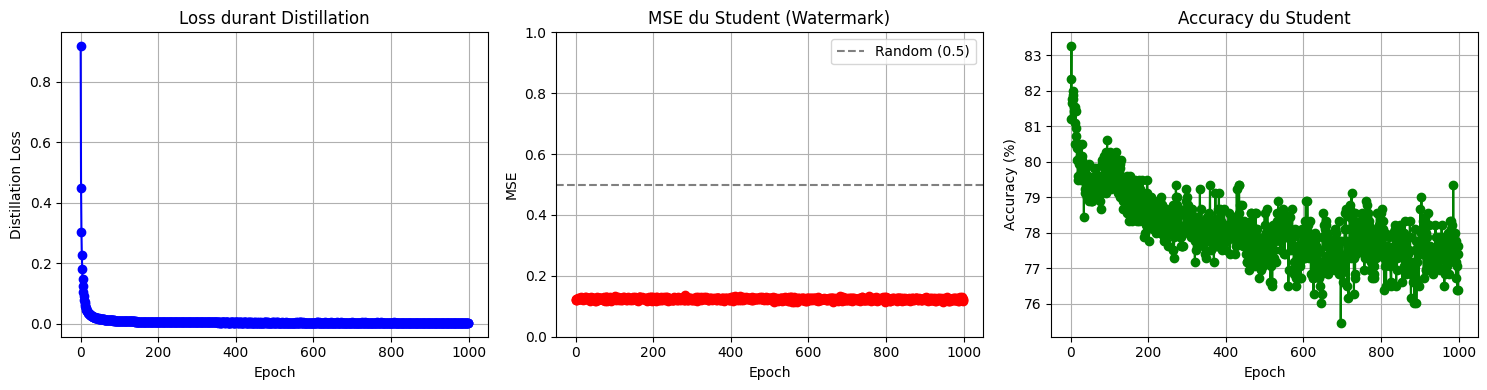


RESUME FINAL
Reconstructed autoencoder MSE: 0.0299
MSE Teacher (watermarked): 0.03
MSE Student (apres distillation): 0.12
Accuracy Student: 77.4%

-> La marque HuFu n'a PAS survecu a la distillation (MSE eleve)


In [8]:
# --- Visualisation des Resultats ---

import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Loss
axes[0].plot(attack_history["loss"], 'b-o')
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Distillation Loss")
axes[0].set_title("Loss durant Distillation")
axes[0].grid(True)

# BER
axes[1].plot(attack_history["mse"], 'r-o')
axes[1].axhline(y=0.5, color='gray', linestyle='--', label='Random (0.5)')
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("MSE")
axes[1].set_title("MSE du Student (Watermark)")
axes[1].set_ylim([0, 1])
axes[1].legend()
axes[1].grid(True)

# Accuracy
axes[2].plot(attack_history["acc"], 'g-o')
axes[2].set_xlabel("Epoch")
axes[2].set_ylabel("Accuracy (%)")
axes[2].set_title("Accuracy du Student")
axes[2].grid(True)

plt.tight_layout()
plt.show()

# Resume final
print("\n" + "=" * 50)
print("RESUME FINAL")
print("=" * 50)
print(f"MSE Teacher (watermarked): {hufu.extract(hufu.saved_keys['watermarked_model'], hufu_dataloader)[0]:.2f}")
print(f"MSE Student (apres distillation): {attack_history['mse'][-1]:.2f}")
print(f"Accuracy Student: {attack_history['acc'][-1]:.1f}%")

if attack_history['mse'][-1] > 0.01:
    print("\n-> La marque HuFu n'a PAS survecu a la distillation (MSE eleve)")
else:
    print("\n-> La marque Hufu a survecu a la distillation (MSE faible)")